In [1]:
import pandas as pd
# from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')
# model_rft = joblib.load('savemodel_rf.sav')


model_etr = joblib.load('savemodel_etr.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')


model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [2]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 

dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [3]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
count,7453.000000,7453.000000,5941.000000,5941.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.016286,0.003318,8.870751,242.699284
std,5.296850,4.429899,0.099475,0.081795,8.619512,108.555287
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241
25%,-1.756650,-2.534061,-0.037983,-0.044471,0.000000,124.116508
50%,2.294543,0.385690,0.019269,0.003562,6.953578,283.216008
75%,5.838650,3.339456,0.072372,0.047412,18.014436,346.200000
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115


Imputing value in the preprocessed dataset

In [4]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [5]:
x_pre = imputer.transform(dfpre)

In [6]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [7]:
# Calculate current and wind speed

dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [8]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [9]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))


In [10]:
# Calculate the True North current direction and split them into quadrants

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [11]:
# Descriptive statistics of the dataset for true north weather direction

dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [12]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [13]:
# SOG threshold according to Abebe20 and Yan21

df = df[df['SOG'] > 5 ]

In [14]:
# Exclude data for the month of June to check the model's forecasting performance 

from sklearn.model_selection import train_test_split

#When performing the split, make sure that the random state is the same as the training script

train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

# Summer
dfMay = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-05']
dfJune = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-06']
dfJuly = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-07']
dfAug = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-08']
dfSep = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-09']
dfOct = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-10']
# Winter
dfNov = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-11']
dfDec = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-12']
dfJan = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-01']
dfFeb = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-02']
dfMar = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-03']
dfApr = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-04']

frames_summer = [dfMay,dfJune,dfJuly,dfAug,dfSep,dfOct]
frames_winter = [dfNov,dfDec,dfJan,dfFeb,dfMar,dfApr]

dfsummer = pd.concat(frames_summer)
dfwinter = pd.concat(frames_winter)
dfyear = test_set

# df_test_set = dfwinter
# df_test_set = dfsummer  
# df_test_set= test_set



In [15]:
dfsummer.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,454.000000,454.000000,454.000000,454.000000,439.000000,416.000000,416.000000,416.000000,416.000000,439.000000,...,454.000000,454.000000,454.000000,416.000000,416.000000,416.000000,454.000000,454.000000,454.000000,454.000000
mean,4379.918502,13.461290,55.234028,285.589553,1.230196,1.568078,4.143271,3.418435,3.739130,286.404432,...,188.075527,90.944052,83.648221,86.917250,88.018205,87.491854,0.095515,6.638722,193.295295,152.414603
std,1781.342388,0.754357,0.103373,5.899112,0.029182,1.277127,1.157140,1.081699,1.034577,5.163974,...,89.016268,58.052230,59.525944,60.098732,54.915231,60.622756,0.072561,3.327474,88.382376,100.647716
min,96.000000,12.219382,55.056343,269.270386,1.176436,0.132310,2.019747,1.615211,2.019747,274.747070,...,63.486661,0.598850,0.261234,0.332100,0.206255,0.090890,0.002006,0.398818,1.098283,2.677540
25%,3314.000000,12.873213,55.144445,282.898376,1.209274,0.614296,3.234556,2.544199,2.900462,283.061645,...,100.752155,38.395213,26.684098,28.856381,38.290612,30.270210,0.042539,4.075977,135.047483,77.014658
50%,4521.500000,13.436779,55.222487,286.700684,1.224719,1.183481,4.139816,3.300575,3.590367,287.830200,...,124.681623,89.864986,70.507662,81.890883,84.925208,81.235539,0.073974,6.303913,201.288368,124.240301
75%,5750.750000,14.084231,55.273789,290.039307,1.245829,2.166916,4.899095,3.956367,4.521775,290.204956,...,278.068077,145.861449,143.729913,146.727181,136.969296,146.967269,0.132445,8.708087,270.937591,236.190471
max,7499.000000,14.671659,55.609090,295.699951,1.310014,6.084314,7.531564,6.950111,7.014300,294.928223,...,303.295177,179.576603,179.325689,179.848992,179.358114,179.810480,0.497666,15.852335,358.771465,359.450078


In [16]:
dfwinter.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,503.000000,503.000000,503.000000,503.000000,488.000000,450.000000,450.000000,450.000000,450.000000,485.000000,...,503.000000,503.000000,503.000000,450.000000,450.000000,450.000000,503.000000,503.000000,503.000000,503.000000
mean,3472.200795,13.399290,55.244343,279.291783,1.259511,1.381991,4.123351,3.198659,3.669909,280.309699,...,188.504441,91.806005,97.159540,84.194220,88.225590,85.313181,0.094145,6.280760,203.426871,152.756617
std,2674.645833,0.773196,0.107981,5.441286,0.030108,0.919409,0.945212,0.888194,0.804168,4.757542,...,89.393560,54.606739,55.399755,52.416613,52.456824,52.853389,0.065388,2.763034,94.158165,100.407252
min,8.000000,12.217122,55.093126,267.245300,1.191707,0.083379,1.681843,1.651161,1.672565,273.151367,...,89.221494,0.029076,1.444688,0.553399,0.121575,0.055169,0.003022,0.427826,0.232451,0.335373
25%,1160.500000,12.614322,55.149434,275.740845,1.240708,0.676355,3.425199,2.508201,3.067744,277.162598,...,100.874351,39.664718,41.918483,36.764125,43.531422,37.980445,0.048672,4.116934,147.858709,78.133231
50%,2516.000000,13.330516,55.232907,278.215088,1.263985,1.182288,4.074743,3.172218,3.614764,278.586304,...,123.916325,97.923209,102.124889,79.904360,86.839193,80.054412,0.075327,6.047215,205.983056,122.967211
75%,6655.500000,14.075363,55.326505,281.254150,1.277931,1.777715,4.757701,3.776314,4.224252,282.548828,...,280.047244,140.204666,145.342033,132.948174,132.513307,131.527584,0.124327,8.008357,280.202556,225.131044
max,7976.000000,14.676100,55.458259,292.722778,1.348105,4.742170,6.995069,5.787758,5.978095,292.849853,...,308.035345,179.858625,179.952696,179.165935,178.076680,178.295216,0.418802,14.347213,358.907188,359.264290


In [17]:
dfyear.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,957.000000,957.000000,957.000000,957.000000,927.000000,866.000000,866.000000,866.000000,866.000000,924.000000,...,957.000000,957.000000,957.000000,866.000000,866.000000,866.000000,957.000000,957.000000,957.000000,957.000000
mean,3902.821317,13.428703,55.239449,282.279440,1.245628,1.471381,4.132920,3.304233,3.703161,283.205357,...,188.300965,91.397095,90.749781,85.502281,88.125969,86.359749,0.094795,6.450577,198.620460,152.594366
std,2337.889892,0.764546,0.105891,6.475851,0.033076,1.109037,1.051785,0.991427,0.922170,5.813493,...,89.168377,56.239614,57.759771,56.221608,53.620796,56.695854,0.068851,3.047510,91.556109,100.468944
min,8.000000,12.217122,55.056343,267.245300,1.176436,0.083379,1.681843,1.615211,1.672565,273.151367,...,63.486661,0.029076,0.261234,0.332100,0.121575,0.055169,0.002006,0.398818,0.232451,0.335373
25%,1832.000000,12.857662,55.146454,276.796387,1.217414,0.648518,3.333151,2.516121,2.969545,277.897705,...,100.855468,38.804565,31.517677,32.222192,41.215199,35.102583,0.045866,4.105194,139.551166,77.207028
50%,3891.000000,13.397246,55.228287,281.913574,1.245543,1.182288,4.087509,3.223243,3.599207,282.612000,...,124.244421,95.245992,90.435400,81.083496,86.071890,80.469025,0.074553,6.126151,203.575325,123.761356
75%,5882.000000,14.079568,55.277420,288.423340,1.270723,1.913521,4.830854,3.864906,4.319880,289.033691,...,279.379130,142.826897,144.654991,138.886399,135.136935,139.899500,0.128141,8.210403,274.642505,231.331274
max,7976.000000,14.676100,55.609090,295.699951,1.348105,6.084314,7.531564,6.950111,7.014300,294.928223,...,308.035345,179.858625,179.952696,179.848992,179.358114,179.810480,0.497666,15.852335,358.907188,359.450078


Exporting File

In [18]:
# df.to_csv('June_update.csv')

Measure performance in Season, data pre processing by dropping unnecessary feature and renaming


In [19]:
# For Summer
dfsummer= dfsummer.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For Winter
dfwinter= dfwinter.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For the whole year of 2021
dfyear= dfyear.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)


In [20]:
#For Summer
dfsummer= dfsummer.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For Winter
dfwinter= dfwinter.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For the whole year
dfyear= dfyear.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [21]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

# For summer 
dfsummer = dfsummer[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]
# For Winter
dfwinter = dfwinter[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

# For the whole year
dfyear = dfyear[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]




Imputing to complete the data

In [22]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [23]:
# Impute for different dataframe 

imputer.fit(dfsummer)
imputer.fit(dfwinter)
imputer.fit(dfyear)

KNNImputer(n_neighbors=50)

In [24]:
xsummer = imputer.transform(dfsummer)
xwinter = imputer.transform(dfwinter)
xyear = imputer.transform(dfyear)

In [25]:
df_summer_tr = pd.DataFrame(xsummer, columns=dfsummer.columns, index=dfsummer.index)
df_winter_tr = pd.DataFrame(xwinter, columns=dfwinter.columns, index=dfwinter.index)
df_year_tr = pd.DataFrame(xyear, columns=dfyear.columns, index=dfyear.index)

In [26]:
# Summer dataset
x_date_s = df_summer_tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date_s = df_summer_tr.sog
# winter dataset
x_date_w = df_winter_tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date_w = df_winter_tr.sog
# Year dataset
x_date_yr = df_year_tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date_yr = df_year_tr.sog

In [27]:
print(f"Amount of the test dataset is {len(x_date_yr)}")
print(f"Amount of the summer dataset is {len(x_date_s)}")
print(f"Amount of the winter dataset is {len(x_date_w)}")

Amount of the test dataset is 957
Amount of the summer dataset is 454
Amount of the winter dataset is 503


In [28]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()
    stadev_rsquared = score_r2.std()
    max_rsquared = score_r2.max()
    min_rsquared = score_r2.min()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()
    stadev_expVar = score_expVar.std()
    max_expVar = score_expVar.max()
    min_expVar = score_expVar.min()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()
    stadev_MAE = score_MAE.std()
    max_MAE = -score_MAE.max()
    min_MAE = -score_MAE.min()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()
    stadev_MAD = score_MAD.std()
    max_MAD = -score_MAD.max()
    min_MAD = -score_MAD.min()



    score_MSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    score_RMSE = np.sqrt(-score_MSE)
    RMSE = score_RMSE.mean()
    stadev_RMSE = score_RMSE.std()
    max_RMSE = score_RMSE.max()
    min_RMSE = score_RMSE.min()


    print(f"Model Performance of {model}")
    print(f"R^2 = {rsquared:0.4f}, std = {stadev_rsquared:0.4f}, max = {max_rsquared:0.4f}, min = {min_rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}, std = {stadev_expVar:0.4f}, max = {max_expVar:0.4f}, min = {min_expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}, std = {stadev_MAE:0.4f}, max = {max_MAE:0.4f}, min = {min_MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}, std = {stadev_RMSE:0.4f}, max = {max_RMSE:0.4f}, min = {min_RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}, std = {stadev_MAD:0.4f}, max = {max_MAD:0.4f}, min = {min_MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_RMSE,score_MAD    

RFR evaluation

In [29]:
# Model performance for one year test data

r2_rfo_yr,expVar_rfo_yr,MAE_rfo_yr,RMSE_rfo_yr,MAD_rfo_yr = evaluate(model_rfr_hpov,x_date_yr,y_date_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 = 0.8680, std = 0.0318, max = 0.9148, min = 0.8030
explained Variance = 0.8697, std = 0.0310, max = 0.9148, min = 0.8053
MAE = 0.6927, std = 0.0731, max = 0.6049, min = 0.8333
RMSE = 1.0521, std = 0.0703, max = 1.2024, min = 0.9711
MAD = 0.4665, std = 0.0555, max = 0.3675, min = 0.5373



In [30]:
# Model performance for winter test data

r2_rfo_w,expVar_rfo_w,MAE_rfo_w,RMSE_rfo_w,MAD_rfo_w = evaluate(model_rfr_hpov,x_date_w,y_date_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 = 0.8176, std = 0.1024, max = 0.9396, min = 0.5625
explained Variance = 0.8302, std = 0.0946, max = 0.9554, min = 0.5965
MAE = 0.7993, std = 0.1536, max = 0.6536, min = 1.1752
RMSE = 1.1322, std = 0.1795, max = 1.5618, min = 0.9452
MAD = 0.5111, std = 0.0880, max = 0.3094, min = 0.6417



In [31]:
# Model performance for summer test data

r2_rfo_s,expVar_rfo_s,MAE_rfo_s,RMSE_rfo_s,MAD_rfo_s = evaluate(model_rfr_hpov,x_date_s,y_date_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 = 0.7065, std = 0.1721, max = 0.8743, min = 0.3694
explained Variance = 0.7179, std = 0.1686, max = 0.8841, min = 0.3839
MAE = 0.8631, std = 0.1792, max = 0.6319, min = 1.2598
RMSE = 1.1467, std = 0.1647, max = 1.5618, min = 0.9401
MAD = 0.6160, std = 0.1007, max = 0.4691, min = 0.7865



ETR evaluation

In [32]:
# Model performance for one year test data

r2_eto_yr,expVar_eto_yr,MAE_eto_yr,RMSE_eto_yr,MAD_eto_yr = evaluate(model_etr_hpov,x_date_yr,y_date_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 = 0.8877, std = 0.0342, max = 0.9312, min = 0.8142
explained Variance = 0.8891, std = 0.0333, max = 0.9314, min = 0.8165
MAE = 0.6541, std = 0.0846, max = 0.5464, min = 0.8150
RMSE = 1.0070, std = 0.0808, max = 1.1395, min = 0.8794
MAD = 0.4570, std = 0.0688, max = 0.3291, min = 0.5594



In [33]:
# Model performance for winter test data

r2_eto_w,expVar_eto_w,MAE_eto_w,RMSE_eto_w,MAD_eto_w = evaluate(model_etr_hpov,x_date_w,y_date_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 = 0.8976, std = 0.0511, max = 0.9619, min = 0.7909
explained Variance = 0.9051, std = 0.0489, max = 0.9733, min = 0.8071
MAE = 0.6468, std = 0.1073, max = 0.5435, min = 0.9188
RMSE = 0.9829, std = 0.1402, max = 1.2985, min = 0.8289
MAD = 0.4546, std = 0.0852, max = 0.2830, min = 0.5514



In [34]:
# Model performance for summer test data

r2_eto_s,expVar_eto_s,MAE_eto_s,RMSE_eto_s,MAD_eto_s = evaluate(model_etr_hpov,x_date_s,y_date_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 = 0.7525, std = 0.1695, max = 0.9543, min = 0.4301
explained Variance = 0.7645, std = 0.1658, max = 0.9543, min = 0.4520
MAE = 0.8093, std = 0.1947, max = 0.5739, min = 1.2969
RMSE = 1.0854, std = 0.1933, max = 1.5884, min = 0.8695
MAD = 0.5851, std = 0.0915, max = 0.4654, min = 0.7427



DT evaluation

In [35]:
r2_dto_yr,expVar_dto_yr,MAE_dto_yr,RMSE_dto_yr,MAD_dto_yr = evaluate(model_dtr_hpov,x_date_yr,y_date_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 = 0.8221, std = 0.0491, max = 0.8919, min = 0.7336
explained Variance = 0.8245, std = 0.0484, max = 0.8919, min = 0.7372
MAE = 0.8164, std = 0.0917, max = 0.6432, min = 1.0147
RMSE = 1.1494, std = 0.0755, max = 1.2435, min = 0.9992
MAD = 0.5431, std = 0.0841, max = 0.3774, min = 0.6872



In [36]:
r2_dto_w,expVar_dto_w,MAE_dto_w,RMSE_dto_w,MAD_dto_w = evaluate(model_dtr_hpov,x_date_w,y_date_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 = 0.6416, std = 0.1850, max = 0.8599, min = 0.3388
explained Variance = 0.6626, std = 0.1844, max = 0.8710, min = 0.3549
MAE = 1.0362, std = 0.2399, max = 0.8061, min = 1.5192
RMSE = 1.3436, std = 0.1878, max = 1.6056, min = 1.1453
MAD = 0.5798, std = 0.1238, max = 0.4538, min = 0.8765



In [37]:
r2_dto_s,expVar_dto_s,MAE_dto_s,RMSE_dto_s,MAD_dto_s = evaluate(model_dtr_hpov,x_date_s,y_date_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 = 0.5648, std = 0.2302, max = 0.8281, min = 0.0703
explained Variance = 0.5835, std = 0.2151, max = 0.8366, min = 0.1608
MAE = 1.0925, std = 0.2403, max = 0.7366, min = 1.5256
RMSE = 1.2806, std = 0.1787, max = 1.6172, min = 0.9813
MAD = 0.7158, std = 0.1439, max = 0.5137, min = 0.9217



ML evaluation

In [38]:
r2_mlr_yr,expVar_mlr_yr,MAE_mlr_yr,RMSE_mlr_yr,MAD_mlr_yr = evaluate(model_mlr_ftr,x_date_yr,y_date_yr)

Model Performance of LinearRegression()
R^2 = 0.6756, std = 0.1514, max = 0.8520, min = 0.4379
explained Variance = 0.6782, std = 0.1503, max = 0.8526, min = 0.4403
MAE = 1.1171, std = 0.0854, max = 1.0067, min = 1.3155
RMSE = 1.2949, std = 0.1334, max = 1.4869, min = 1.1186
MAD = 0.8610, std = 0.0942, max = 0.7015, min = 0.9899



In [39]:
r2_mlr_w,expVar_mlr_w,MAE_mlr_w,RMSE_mlr_w,MAD_mlr_w = evaluate(model_mlr_ftr,x_date_w,y_date_w)

Model Performance of LinearRegression()
R^2 = 0.6619, std = 0.1712, max = 0.8726, min = 0.4038
explained Variance = 0.6803, std = 0.1696, max = 0.8827, min = 0.4157
MAE = 1.1697, std = 0.2175, max = 0.8150, min = 1.5722
RMSE = 1.3233, std = 0.2216, max = 1.6584, min = 1.0407
MAD = 0.9289, std = 0.2268, max = 0.6126, min = 1.3181



In [40]:
r2_mlr_s,expVar_mlr_s,MAE_mlr_s,RMSE_mlr_s,MAD_mlr_s = evaluate(model_mlr_ftr,x_date_s,y_date_s)

Model Performance of LinearRegression()
R^2 = 0.5988, std = 0.2439, max = 0.9455, min = 0.1346
explained Variance = 0.6118, std = 0.2461, max = 0.9463, min = 0.1362
MAE = 1.1151, std = 0.2726, max = 0.7025, min = 1.5260
RMSE = 1.2252, std = 0.1743, max = 1.5634, min = 0.9422
MAD = 0.8598, std = 0.2241, max = 0.5417, min = 1.1671



In [41]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = np.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MSE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

Check absolute performance of the model on test data

ETR

In [42]:
# Year dataset
evaluate_SOG(model_etr_hpov,x_date_yr,y_date_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9682
Explained Variance SOG = 0.9682
MSE SOG = 0.3470 Knots
RMSE SOG = 0.5527 Knots
MAD SOG = 0.2138 Knots
MAPE SOG = 2.3484 %


In [43]:
evaluate_SOG(model_etr_hpov,x_date_w,y_date_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9840
Explained Variance SOG = 0.9840
MSE SOG = 0.2873 Knots
RMSE SOG = 0.4101 Knots
MAD SOG = 0.1955 Knots
MAPE SOG = 2.0303 %


In [44]:
evaluate_SOG(model_etr_hpov,x_date_s,y_date_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9459
Explained Variance SOG = 0.9468
MSE SOG = 0.4132 Knots
RMSE SOG = 0.6764 Knots
MAD SOG = 0.2389 Knots
MAPE SOG = 2.7009 %


RFR

In [45]:
evaluate_SOG(model_rfr_hpov,x_date_yr,y_date_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9659
Explained Variance SOG = 0.9660
MSE SOG = 0.3349 Knots
RMSE SOG = 0.5721 Knots
MAD SOG = 0.1868 Knots
MAPE SOG = 2.2897 %


In [46]:
evaluate_SOG(model_rfr_hpov,x_date_w,y_date_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9841
Explained Variance SOG = 0.9842
MSE SOG = 0.2650 Knots
RMSE SOG = 0.4085 Knots
MAD SOG = 0.1726 Knots
MAPE SOG = 1.9399 %


In [47]:
evaluate_SOG(model_rfr_hpov,x_date_s,y_date_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9402
Explained Variance SOG = 0.9414
MSE SOG = 0.4123 Knots
RMSE SOG = 0.7107 Knots
MAD SOG = 0.2148 Knots
MAPE SOG = 2.6773 %


DTR


In [48]:
evaluate_SOG(model_dtr_hpov,x_date_yr,y_date_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.9010
Explained Variance SOG = 0.9012
MSE SOG = 0.6291 Knots
RMSE SOG = 0.9746 Knots
MAD SOG = 0.4198 Knots
MAPE SOG = 4.2093 %


In [49]:
evaluate_SOG(model_dtr_hpov,x_date_w,y_date_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.9318
Explained Variance SOG = 0.9319
MSE SOG = 0.5614 Knots
RMSE SOG = 0.8461 Knots
MAD SOG = 0.3902 Knots
MAPE SOG = 3.9286 %


In [50]:
evaluate_SOG(model_dtr_hpov,x_date_s,y_date_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.8569
Explained Variance SOG = 0.8590
MSE SOG = 0.7041 Knots
RMSE SOG = 1.0996 Knots
MAD SOG = 0.4505 Knots
MAPE SOG = 4.5202 %


MLR

In [51]:
evaluate_SOG(model_mlr_ftr,x_date_yr,y_date_yr)

Model Performance of LinearRegression()
R^2 SOG = 0.6975
Explained Variance SOG = 0.6985
MSE SOG = 1.1389 Knots
RMSE SOG = 1.7036 Knots
MAD SOG = 0.9077 Knots
MAPE SOG = 7.6431 %


In [52]:
evaluate_SOG(model_mlr_ftr,x_date_s,y_date_s)

Model Performance of LinearRegression()
R^2 SOG = 0.7143
Explained Variance SOG = 0.7187
MSE SOG = 1.1503 Knots
RMSE SOG = 1.5539 Knots
MAD SOG = 0.9505 Knots
MAPE SOG = 7.3177 %


In [53]:
evaluate_SOG(model_mlr_ftr,x_date_w,y_date_w)

Model Performance of LinearRegression()
R^2 SOG = 0.6816
Explained Variance SOG = 0.6817
MSE SOG = 1.1286 Knots
RMSE SOG = 1.8282 Knots
MAD SOG = 0.8706 Knots
MAPE SOG = 7.9368 %


In [54]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.3f}x {b:+.3f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$kts$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$kts$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend()



0.9491611344303913
y = 1.0 * x + 0.5
0.9009883661825288
y = 0.9 * x + 1.8


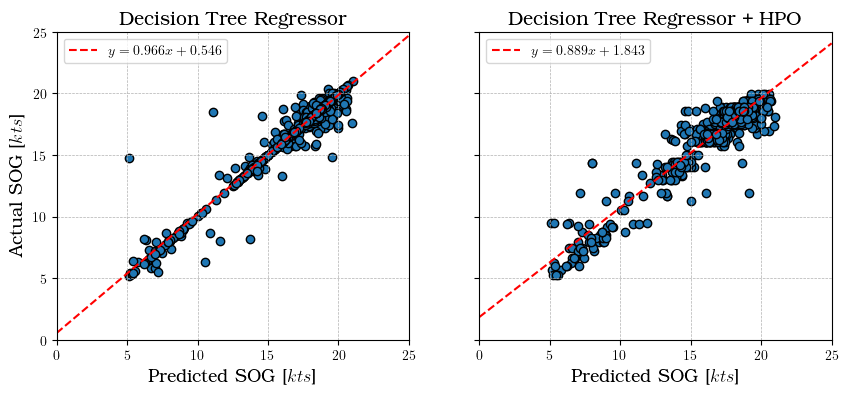

In [55]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.9647375970555353
y = 0.9 * x + 1.1
0.9658808779013827
y = 0.9 * x + 1.1


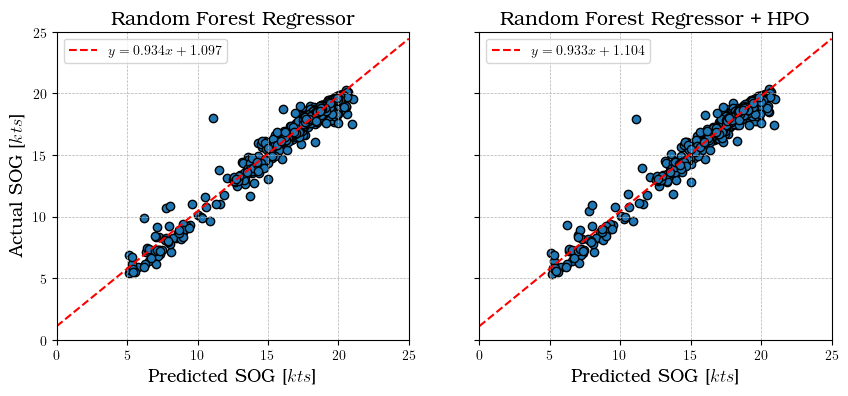

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

In [57]:
# fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# plt.sca(axes[0])
# pred_plot(model_etr,'Extra Trees Regressor',x_date,y_date)
# plt.sca(axes[1])
# pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date,y_date)
# plt.ylabel("")
# plt.show()

Evaluation using Cross Validation

In [58]:
# scores_test = [r2_rf,r2_et,r2_dt,r2_mlr]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# # ax = fig.add_axes([0, 0, 1, 1])
# fig,ax = plt.subplots()
# plt.title("Validation Data Model Performance")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0.2,1.0)
# plt.boxplot(scores_test,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels(['RFR', 'ETR',
#                     'DTR','MLR'])
# plt.show()

In [59]:
# scores_test = [-RMSE_rf,-RMSE_et,-RMSE_dt,-RMSE_mlr]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# # ax = fig.add_axes([0, 0, 1, 1])
# fig,ax = plt.subplots()
# plt.title("Validation Data Model Performance")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,1.6)
# plt.boxplot(scores_test,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels(['RFR', 'ETR',
#                     'DTR','MLR'])
# plt.show()

Optimization comparison

<Figure size 500x300 with 0 Axes>

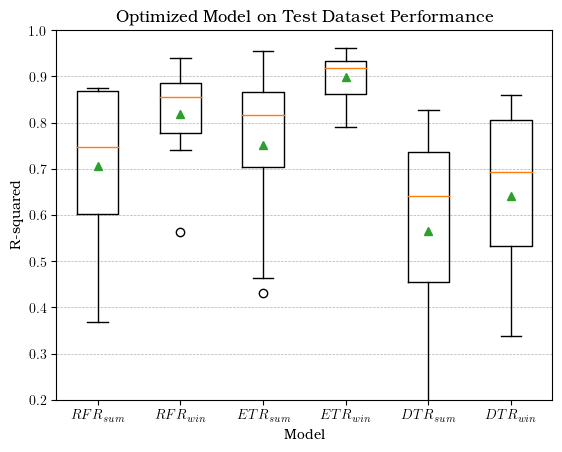

In [60]:
scores_opt = [r2_rfo_s,r2_rfo_w,r2_eto_s,r2_eto_w,r2_dto_s,r2_dto_w]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model on Test Dataset Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.ylim(0.2,1.0)
plt.yscale('linear')
ax.boxplot(scores_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'$RFR_{sum}$', r'$RFR_{win}$',
                    r'$ETR_{sum}$', r'$ETR_{win}$',
                    r'$DTR_{sum}$',r'$DTR_{win}$'])
plt.show()

<Figure size 500x300 with 0 Axes>

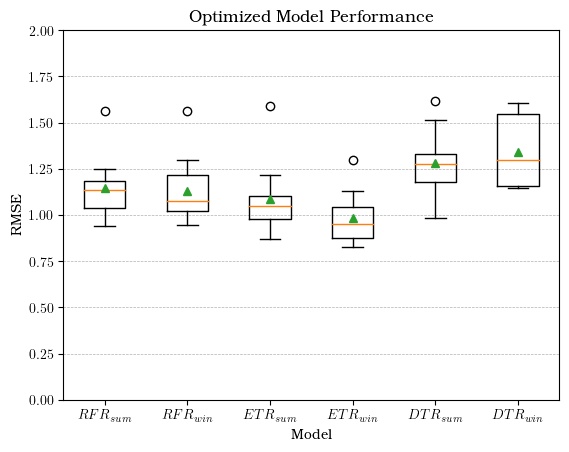

In [61]:
rmse_opt = [RMSE_rfo_s,RMSE_rfo_w,RMSE_eto_s,RMSE_eto_w,RMSE_dto_s,RMSE_dto_w]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0,2)
ax.boxplot(rmse_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'$RFR_{sum}$', r'$RFR_{win}$',
                    r'$ETR_{sum}$', r'$ETR_{win}$',
                    r'$DTR_{sum}$',r'$DTR_{win}$'])
plt.show()

In [62]:
# scores_opt = [r2_rf,r2_rfc,r2_et,r2_etc,r2_dt,r2_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of amount of data")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.ylim(0.2,1.0)
# plt.yscale('linear')
# ax.boxplot(scores_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
# plt.show()

In [63]:
# rmse_opt = [-RMSE_rf,-RMSE_rfc,-RMSE_et,-RMSE_etc,-RMSE_dt,-RMSE_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of Amount of Data")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,1.6)
# ax.boxplot(rmse_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
# plt.show()

In [64]:
# # define the true objective function
# def objective(x, a, b, c):
# 	return a * x + b * x**2 + c

STW Calculation

In [65]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

#Test data

# ETR
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)

# RFR
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)


# DTR
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)

# MLR  
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
ydate_pred__mlr_yr = label_predict(model_mlr_ftr,x_date_yr)


# For actual results

# Yearly dataset

dfprog_sog_yr = pd.Series(y_date_yr,name="sog_act_yr").to_frame()
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)
ydate_pred_mlr_yr = label_predict(model_mlr_ftr,x_date_yr)
dfprog_sog_yr["sog_pred_yr"] = ydate_pred_yr
dfprog_sog_yr["sog_pred_rf_yr"] = ydate_pred_rf_yr
dfprog_sog_yr["sog_pred_dt_yr"] = ydate_pred_dt_yr
dfprog_sog_yr["sog_pred_mlr_yr"] = ydate_pred_mlr_yr
dfprog_sog_yr["gamma_yr"] = df_year_tr["truenorthcurrentdir"]
dfprog_sog_yr["nwinddir_yr"] = df_year_tr["truenorthwinddir"]
dfprog_yr = pd.concat([x_date_yr,dfprog_sog_yr],axis=1)


# Winter dataset
dfprog_sog_w = pd.Series(y_date_w,name="sog_act_w").to_frame()
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
dfprog_sog_w["sog_pred_w"] = ydate_pred_w
dfprog_sog_w["sog_pred_rf_w"] = ydate_pred_rf_w
dfprog_sog_w["sog_pred_dt_w"] = ydate_pred_dt_w
dfprog_sog_w["sog_pred_mlr_w"] = ydate_pred_mlr_w
dfprog_sog_w["gamma_w"] = df_winter_tr["truenorthcurrentdir"]
dfprog_sog_w["nwinddir_w"] = df_winter_tr["truenorthwinddir"]
dfprog_w = pd.concat([x_date_w,dfprog_sog_w],axis=1)

# Summer Dataset
dfprog_sog_s = pd.Series(y_date_s,name="sog_act_s").to_frame()
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
dfprog_sog_s["sog_pred_s"] = ydate_pred_s
dfprog_sog_s["sog_pred_rf_s"] = ydate_pred_rf_s
dfprog_sog_s["sog_pred_dt_s"] = ydate_pred_dt_s
dfprog_sog_s["sog_pred_mlr_s"] = ydate_pred_mlr_s
dfprog_sog_s["gamma_s"] = df_summer_tr["truenorthcurrentdir"]
dfprog_sog_s["nwinddir_s"] = df_summer_tr["truenorthwinddir"]
dfprog_s = pd.concat([x_date_s,dfprog_sog_s],axis=1)




# dfprog_sog = pd.Series(y_date_s,name="sog_act_s").to_frame()
# dfprog_sog["sog_act_w"] = y_date_w
# #ETR
# dfprog_sog["sog_pred_s"] = ydate_pred_s
# dfprog_sog["sog_pred_w"] = ydate_pred_w
# #RFR
# dfprog_sog["sog_pred_rf_s"] = ydate_pred_rf_s
# dfprog_sog["sog_pred_rf_w"] = ydate_pred_rf_w
# #DTR
# dfprog_sog["sog_pred_dt_s"] = ydate_pred_dt_s
# dfprog_sog["sog_pred_dt_s"] = ydate_pred_dt_s
# #MLR one year
# dfprog_sog["sog_pred_mlr"] = ydate_pred_mlr
# #Current wind direction summer winter
# dfprog_sog["gamma_s"] = df_summer_tr["truenorthcurrentdir"]
# dfprog_sog["gamma_w"] = df_winter_tr["truenorthcurrentdir"]
# dfprog_sog["nwinddir_s"] = df_summer_tr["truenorthwinddir"]
# dfprog_sog["nwinddir_s"] = df_summer_tr["truenorthwinddir"]

# dfprog = pd.concat([x_date,dfprog_sog],axis=1)
# print(dfprog_sog)

In [66]:
dfprog_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 6981 to 2163
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     503 non-null    float64
 1   waveperiod           503 non-null    float64
 2   surftemp             503 non-null    float64
 3   windwaveswellheight  503 non-null    float64
 4   draught              503 non-null    float64
 5   cog                  503 non-null    float64
 6   heading              503 non-null    float64
 7   windspeed            503 non-null    float64
 8   curspeed             503 non-null    float64
 9   truewinddir          503 non-null    float64
 10  truecurrentdir       503 non-null    float64
 11  truewavedir          503 non-null    float64
 12  sog_act_w            503 non-null    float64
 13  sog_pred_w           503 non-null    float64
 14  sog_pred_rf_w        503 non-null    float64
 15  sog_pred_dt_w        503 non-null   

In [67]:
dfprog_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454 entries, 3198 to 6341
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     454 non-null    float64
 1   waveperiod           454 non-null    float64
 2   surftemp             454 non-null    float64
 3   windwaveswellheight  454 non-null    float64
 4   draught              454 non-null    float64
 5   cog                  454 non-null    float64
 6   heading              454 non-null    float64
 7   windspeed            454 non-null    float64
 8   curspeed             454 non-null    float64
 9   truewinddir          454 non-null    float64
 10  truecurrentdir       454 non-null    float64
 11  truewavedir          454 non-null    float64
 12  sog_act_s            454 non-null    float64
 13  sog_pred_s           454 non-null    float64
 14  sog_pred_rf_s        454 non-null    float64
 15  sog_pred_dt_s        454 non-null   

In [68]:
print(dfprog_sog_s.describe())

        sog_act_s  sog_pred_s  sog_pred_rf_s  sog_pred_dt_s  sog_pred_mlr_s  \
count  454.000000  454.000000     454.000000     454.000000      454.000000   
mean    17.264115   17.177409      17.164986      17.131843       17.072014   
std      2.910371    2.702640       2.723697       2.692878        2.282225   
min      5.224523    5.996528       5.849809       5.274447        4.642381   
25%     16.740121   16.674608      16.730421      16.681541       17.289464   
50%     18.172679   18.141445      18.155401      18.081634       17.739013   
75%     18.949954   18.711128      18.696831      18.548179       18.010761   
max     21.005331   20.150596      20.339932      19.970330       19.977842   

          gamma_s  nwinddir_s  
count  454.000000  454.000000  
mean   152.414603  193.295295  
std    100.647716   88.382376  
min      2.677540    1.098283  
25%     77.014658  135.047483  
50%    124.240301  201.288368  
75%    236.190471  270.937591  
max    359.450078  358.771465  


In [69]:
print(dfprog_sog_w.describe())

        sog_act_w  sog_pred_w  sog_pred_rf_w  sog_pred_dt_w  sog_pred_mlr_w  \
count  503.000000  503.000000     503.000000     503.000000      503.000000   
mean    16.748089   16.771503      16.776308      16.775732       16.732220   
std      3.243255    3.109700       3.114336       3.069156        2.687244   
min      5.104109    5.369318       5.365980       5.274447        4.416551   
25%     16.593366   16.639789      16.557906      16.673820       17.013089   
50%     17.977196   17.945557      17.969366      17.949333       17.487165   
75%     18.612312   18.530081      18.539630      18.548179       17.909396   
max     20.701952   19.979479      20.108148      19.582539       24.284774   

          gamma_w  nwinddir_w  
count  503.000000  503.000000  
mean   152.756617  203.426871  
std    100.407252   94.158165  
min      0.335373    0.232451  
25%     78.133231  147.858709  
50%    122.967211  205.983056  
75%    225.131044  280.202556  
max    359.264290  358.907188  


In [70]:
print(dfprog_sog_yr.describe())

       sog_act_yr  sog_pred_yr  sog_pred_rf_yr  sog_pred_dt_yr  \
count  957.000000   957.000000      957.000000      957.000000   
mean    16.992892    16.964064       16.960696       16.944671   
std      3.098953     2.929186        2.940409        2.900716   
min      5.104109     5.369318        5.365980        5.274447   
25%     16.682544    16.662640       16.667937       16.673820   
50%     18.054214    18.010013       18.043999       18.081634   
75%     18.716411    18.623395       18.618055       18.548179   
max     21.005331    20.150596       20.339932       19.970330   

       sog_pred_mlr_yr    gamma_yr  nwinddir_yr  
count       957.000000  957.000000   957.000000  
mean         16.893418  152.594366   198.620460  
std           2.507751  100.468944    91.556109  
min           4.416551    0.335373     0.232451  
25%          17.131410   77.207028   139.551166  
50%          17.646337  123.761356   203.575325  
75%          17.966183  231.331274   274.642505  
max  

In [71]:
def sog_corr(sog,gamma,heading,current_speed):
    # Conversion of predicted SOG to m/s
    vgms = sog/1.9438
    rad_gamma = np.deg2rad(gamma)
    rad_cog = np.deg2rad(heading)
    # Calculation of the predicted x-component of SOG

    vgx = vgms * np.sin(rad_cog)
    vcx = current_speed * np.sin(rad_gamma)
    stw_x = vgx - vcx

    # Calculation of the predicted y-component of SOG 

    vgy = vgms * np.cos(rad_cog)
    vcy = current_speed * rad_gamma
    stw_y = vgy - vcy

    vwms_p = np.sqrt(stw_x**2 + stw_y**2)
    stw_pred = vwms_p*1.9438

    return stw_pred

In [72]:
# STW conversion Year

# Actual
stw_act_yr = sog_corr(dfprog_yr['sog_act_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_act_yr'] = stw_act_yr
# ETR
stw_pred_et_yr = sog_corr(dfprog_yr['sog_pred_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_yr'] = stw_pred_et_yr
# RFR
stw_pred_rf_yr = sog_corr(dfprog_yr['sog_pred_rf_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_rf_yr'] = stw_pred_rf_yr
# DTR
stw_pred_dt_yr = sog_corr(dfprog_yr['sog_pred_dt_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_dt_yr'] = stw_pred_dt_yr
# MLR
stw_pred_mlr_yr = sog_corr(dfprog_yr['sog_pred_mlr_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_s['stw_pred_mlr_yr'] = stw_pred_mlr_yr



In [73]:
print(dfprog_yr.describe())

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        957.000000  957.000000  957.000000           957.000000   
mean         282.279440    3.697466  283.215909             0.771864   
std            6.475851    0.879113    5.718259             0.541748   
min          267.245300    1.672565  273.151367             0.075465   
25%          276.796387    3.061307  277.980225             0.374414   
50%          281.913574    3.616586  282.726074             0.662103   
75%          288.423340    4.216455  288.822632             0.943902   
max          295.699951    7.014300  294.928223             3.236886   

          draught         cog     heading   windspeed    curspeed  \
count  957.000000  957.000000  957.000000  957.000000  957.000000   
mean     5.227477  196.729343  188.300965    6.450577    0.094795   
std      0.185996   86.724148   89.168377    3.047510    0.068851   
min      4.742534   56.023445   63.486661    0.398818    0.002006   
25%   

In [74]:
# STW conversion Summer 

# Actual
stw_act_s = sog_corr(dfprog_s['sog_act_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_act_s'] = stw_act_s
# ETR
stw_pred_et_s = sog_corr(dfprog_s['sog_pred_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_s'] = stw_pred_et_s
# RFR
stw_pred_rf_s = sog_corr(dfprog_s['sog_pred_rf_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_rf_s'] = stw_pred_rf_s
# DTR
stw_pred_dt_s = sog_corr(dfprog_s['sog_pred_dt_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_dt_s'] = stw_pred_dt_s
# MLR
stw_pred_mlr_s = sog_corr(dfprog_s['sog_pred_mlr_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_mlr_s'] = stw_pred_mlr_s



In [75]:
print(dfprog_s.describe())

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        454.000000  454.000000  454.000000           454.000000   
mean         285.589553    3.729816  286.326507             0.817906   
std            5.899112    0.992092    5.100742             0.628985   
min          269.270386    2.019747  274.747070             0.084262   
25%          282.898376    2.945056  283.051697             0.356768   
50%          286.700684    3.601665  287.582764             0.670919   
75%          290.039307    4.362177  290.184113             1.017011   
max          295.699951    7.014300  294.928223             3.236886   

          draught         cog     heading   windspeed    curspeed  \
count  454.000000  454.000000  454.000000  454.000000  454.000000   
mean     5.298229  196.058776  188.075527    6.638722    0.095515   
std      0.165597   87.546749   89.016268    3.327474    0.072561   
min      4.742534   56.023445   63.486661    0.398818    0.002006   
25%   

In [76]:
# STW conversion Winter

# Actual
stw_act_w = sog_corr(dfprog_w['sog_act_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_act_w'] = stw_act_w
# ETR
stw_pred_et_w = sog_corr(dfprog_w['sog_pred_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_w'] = stw_pred_et_w
# RFR
stw_pred_rf_w = sog_corr(dfprog_w['sog_pred_rf_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_rf_w'] = stw_pred_rf_w
# DTR
stw_pred_dt_w = sog_corr(dfprog_w['sog_pred_dt_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_dt_w'] = stw_pred_dt_w
# MLR
stw_pred_mlr_w = sog_corr(dfprog_w['sog_pred_mlr_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_mlr_w'] = stw_pred_mlr_w

In [77]:
# # Predicted SOG from RF model

# stw_pred_rf = sog_corr(dfprog_sog['sog_pred_rf'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_rf'] = stw_pred_rf

In [78]:
# # Predicted SOG from DT model

# stw_pred_dt = sog_corr(dfprog_sog['sog_pred_dt'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_dt'] = stw_pred_dt

In [79]:
# # Predicted SOG from MLR model

# stw_pred_mlr = sog_corr(dfprog_sog['sog_pred_mlr'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_mlr'] = stw_pred_mlr

In [80]:
# # Actual SOG

# stw_pred_act = sog_corr(dfprog_sog['sog_act'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_act'] = stw_pred_act

In [81]:
# dfprog.describe()

Holtrop Mennen FOC function

In [82]:
def foc_fun(stw,T_dyn,windspeed,truewindir,H_s,truewavedir):
    # Ship Information, that are readily available in ship specification
    loa = 158 # ship overall length
    lwl = 144.8 # ship waterline length, m
    lpp = 0.97*lwl # ship perpendicular length , m, according to information
    B = 24.5 # Ship breadth, m
    depth = 13.8 # Ship depth. m
    T_n = 5.85 # Nominal max draught , m
    # T_n = 5.7 # Nominal design draught , m
    dwt = 5110 # ship dead weight , t
    V_n = 17.7 # ship design speed, knots
    # V_n = 18 # ship design speed, knots


    # Environmental Constants

    g = 9.805 # gravity, kg/ms^2 
    rho_sea = 1025 # kg/m3
    nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
    rho_air = 1.25 # density air 

    # Any other additional ship parameters beyond here are approximated based on literature review.

    # Convert STW to m/s, stw with only current correction

    stw_ms = stw / 1.94384

    # Switch between actual and predicted here 
    # Calculation for Block coefficient,C_b, according to Schneekluth and Bertram 1998
    # Then Froude number is required

    V_n = 17.7/1.94384
    # V_n = 18/1.94384

    Fr_n = V_n / math.sqrt(g*lwl)
    # print(f"Froude Number {Fr_n:0.4f}")

    C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
    # print(f"C_b {C_b:0.4f}")

    # calculation for midship section coefficient, C_m according to Jensen from Birk

    C_m = 1 / (1+(1-C_b)**3.5)
    # print(f"C_m {C_m:0.4f}")

    # prismatic coefficient C_p can be calculated according to Biran

    C_p = C_b/C_m 
    # print(f"C_p {C_p:0.4f}")

    # Displacement calculation according to Barras 

    dsp = C_b * lwl * B * T_n

    # print(f"dsp {dsp:0.4f} m^3")

    # coefficient c14 to account for stern shape according to holtrop mennen

    C_stern = 10 # assume u shaped stern
    c14 = 1 + 0.011*C_stern 
    
    # print(f"c14 {c14:0.4f}")

    # Calculate length of run according to holtrop mennen

    # lcb = -2/100 # according to Barras
    lcb = -(0.44*Fr_n - 0.094) # according to Guldhammer and Harvald

    # print(f"lcb {lcb:0.4f}")

    # L in holtrop mennen is lwl

    lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))

    # print(f"lr {lr:0.4f} m")

    # now the (1+k1) can be calculated

    k1a = 0.487118*c14*(B/lwl)**1.06806
    k1b = (T_dyn/lwl)**0.46106
    k1c = (lwl/lr)**0.121563
    k1d = (lwl**3/dsp)**0.36486
    k1e = (1-C_p)**-0.604247

    k1_const = 0.93 + k1a*k1b*k1c*k1d*k1e

    # print(f"k1_const {k1_const.mean():0.4f}")

    # Calculate Reynold number and Coefficient of Friction C_f. Here, the C_f will be dynamic and depend on the velocity of the ship

    Re =( stw_ms * lwl ) / nu_sea
    C_f = 0.075 / (np.log10(Re-2)**2)

    # print(f"Mean Reynold Number {Re.mean():0.2f}")
    # print(f"Mean Coefficient of friction {C_f.mean():0.6f}")
    
    # Calculate the appendage area of bare hull S_bh
    # Formula according to Holtrop Mennen

    # Calculate the waterplane area coefficient 
    # Formula according to Schneekluth and Bertram

    C_wp = (1+2*C_b)/3
    # print(f"C_wp {C_wp:0.4f}")

    # Calculate transverse bulb area A_bt, Transom area A_t and immersed midship section area A_m according to Kim 2019

    # dfprog['A_m'] = B*dfprog['draught']*C_m
    # Borrow estimation of Am from Guldahmmer and Harvald
    A_m = dsp/(lpp*C_p)
    A_t = 0.051 * A_m
    A_bt = 0.085*A_m # From approximation of Kracht78, Similar to Charcalis
    # print(f"A_m {A_m:0.2f} m^2")
    # print(f"A_t {A_t:0.4f} m^2")
    # print(f"A_bt {A_bt:0.4f} m^2")

    sbh_a = lwl*(2*T_dyn+B)*math.sqrt(C_m)
    sbh_b = 0.453
    sbh_c = 0.4425*C_b
    sbh_d = 0.2862*C_m
    sbh_e = 0.003467*(B/T_dyn)
    sbh_f = 0.3696*C_wp
    sbh_g = 2.38*A_bt/C_b

    S_bh = sbh_a*(sbh_b+sbh_c-sbh_d+sbh_e+sbh_f)+sbh_g

    # print(f"S_bh {S_bh.mean():0.4f} m^2")

    # Calculate R_f

    R_f = 0.5 * rho_sea * stw_ms**2 * C_f * S_bh * k1_const

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Frictional Resistance {R_f.mean():0.2f} N")
    
    # Calculate resistance due to appendage

    # Assume S_app
    # Taken from Holtrop Mennen worked example
    # S_app = 50 # m^2 

    # Calculation of appendage area according to Hollenbach method, the formula is for twin screw ship

    # Lower limit
    S_app_lo = S_bh.mean()*(0.028+0.01*math.exp(-(lpp*T_n)/1000))

    # Upper limit
    S_app_hi = S_bh.mean()*(0.0325+0.045*math.exp(-(lpp*T_n)/1000))

    # print(f"S_app between {S_app_lo:.02f} and {S_app_hi:.02f} according to Hollenbach")

    # The following appendage area are scaled from the picture of the ship
    # Constant k here means (1+k_2) !

    D_shaft = 0.55 # m, approx
    l_shaft = 13.54 # m, approx

    S_app_shaft = 2*math.pi * D_shaft * l_shaft
    k2_shaft = 3   

    h_rudder = 4.06 #m, approx
    B_rudder = 1.99 #m, approx
    S_app_rudder = 2 * h_rudder * B_rudder #m, two side
    k2_rudder = 3

    h_skeg = 4.41 #m, approx
    l_skeg = 26.23 #m, approx
    S_app_skeg =  h_skeg * l_skeg #two side (triangle)
    k2_skeg = 1.5

    S_app = S_app_shaft + S_app_rudder + S_app_skeg

    k2_const = (k2_shaft*S_app_shaft + k2_rudder*S_app_rudder + k2_skeg*S_app_skeg)/S_app

    # print(f"Wetted area of hull is {S_bh.mean():0.2f}")
    # print(f"(1+k2) equivalent {k2_const:0.2f}")
    # print(f"Total Appendage area is {S_app:0.4f}")
    # # from holtrop mennen, take case of twin screw
    # k2_const = 2.8

    # Add resistance due to Bow Thrusters

    d_th = 2.15 #m, approx

    # Use formula from Hollenach
    C_dth = 0.003 + 0.003*((10*d_th/T_n)-1)
    # C_dth = 0.003 # The picture shows that the thruster are fairly parallel to midship area
    # There are two bow thruster in this ship
    R_th = rho_sea*stw_ms**2*math.pi*d_th**2*C_dth

    # print(f"Friction due to bow thrusters {R_th.mean():0.2f} N")

    R_app = (0.5 * rho_sea * stw_ms**2 * C_f * S_app *k2_const) + 2*R_th

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Appendage Friction {R_app.mean():0.2f} N")

    # Calculate wave-making and wave-breaking resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")
    # print(f"B/lwl = {B/lwl:0.2f}")
    # print(f"lwl^3/displacemt = {lwl**3/dsp:0.2f}")
    # print(f"C_p = {C_p:0.4f}")


    c7 = B/lwl
    T_fwd = T_dyn # See reasoning from Rakke16 
    h_b = 0.6*T_n # must not exceed 0.6 T_f, here T_n = T_f (design), reasong and coefficient value taken from Rakke
    
    # print(f"h_B {h_b:0.4f}")

    # All formulas here are listed by Holtrop Mennen

    c3 = 0.56 * A_bt**1.5 / (B*T_dyn*(0.31*np.sqrt(A_bt)+T_fwd-h_b))
    c2 = np.exp(-1.89*np.sqrt(c3))
    c5 = 1 - 0.8*(A_t/(B*T_dyn*C_m))
    lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
    c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
    m_1 = 0.0140407 * (lwl/T_dyn) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
    c15 = -1.69385

    # Use dynamic Froude here to refect the actual resistance due to ship movement 

    Fr_n_dyn = stw_ms / math.sqrt(g*lwl)
    # Updated formula use m_4
    m4 = 0.4 * c15 * np.exp(-0.034*Fr_n_dyn **-3.29)

    i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
    c1 = 2223105 * c7**3.78613 * (T_dyn/B)**1.07961*(90-i_e)**-1.37565
    d = -0.9

    # print(f"i_e = {i_e:0.4f}")

    # Use updated formula with m4

    R_w = c1*c2*c5*dsp*g*rho_sea*np.exp(m_1*Fr_n_dyn **d+m4*np.cos(lambda_const*Fr_n_dyn **-2))

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Wave resistance {R_w.mean():0.2f} N")

    # Calculate Resistance due to Bulbous Bow
    # Calculate effect of forward sinkage h_f and local wave height at bow h_w

    P_b = 0.56*np.sqrt(A_bt)/(T_fwd-1.5*h_b)
    Fn_i = stw_ms / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(A_bt))+0.15*stw_ms**2)
    R_b = 0.11 * np.exp(-3*P_b**-2)*Fn_i**3*A_bt**1.5*rho_sea*g/(1+Fn_i**2)

    # print(f"Emergence of bulb Pb {P_b.mean():0.4f}")
    # print(f"Immersion Froude number Fn_i {Fn_i.mean():0.2f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to bulbous bow {R_b.mean():0.2f} N")    

    #Calculate Transom Resistance 

    Fn_tr = stw_ms / np.sqrt(2*g*A_t/(B+(B*C_wp)))

    # print(f"Froude for Transom {Fn_tr.mean():0.4f}")

    # Use condition to calculate Froude due to transom

    cond_Fn_tr = [Fn_tr < 5 ]
    cond_c6 = [0.2*(1-0.2*Fn_tr)]

    c6 = np.select(cond_Fn_tr,cond_c6,0)
    R_tr = 0.5*rho_sea*10**2*A_t*c6

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to transom {R_tr.mean():0.2f} N")

    # Model ship correlation resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")

    cond_Tf_lwl = [(T_fwd/lwl) <= 0.04 ]
    cond_c4 = [T_fwd/lwl]
    c4 = np.select(cond_Tf_lwl,cond_c4,0.04)

    C_a = 0.00546*(lwl+100)**-0.16 - 0.002 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-c4)

    R_a = 0.5*rho_sea*stw_ms**2*C_a*(S_bh+S_app)

    # print(f"C_a {C_a.mean()}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Correlation allowance resistance {R_a.mean():0.2f} N")

    # Calculate Additional Resistance, consist of wind resistance and wave resistance
    # Calculate Apparent velocities and Apparent Angle 

    V_aw = np.sqrt(windspeed**2 + stw_ms**2 + 2*windspeed*stw_ms*np.cos(np.deg2rad(truewindir)))

    awa_c1 = (windspeed/V_aw)*np.sin(np.deg2rad(truewindir))

    # Epsilon is Apparent Wind Angle AWA

    epsilon = np.rad2deg(np.arcsin(awa_c1))

    # Values and method from Blendermann

    C_DlAf = 0.45
    A_f = 325.3
    A_l = 2125.8
    C_Dt = 0.9
    delta = 0.8
    C_Dl = C_DlAf * A_f / A_l
    L_bwl = 43.75 # m, acquired from picture

    Raa_const1 = (rho_air/2) * V_aw**2 * A_l * C_Dl
    Raa_const2 = np.cos(np.deg2rad(epsilon))
    Raa_const3 = 1 - (delta/2) * ((1-(C_Dl/C_Dt))*(np.sin(np.deg2rad(2*epsilon)))**2)

    R_aa = Raa_const1 * Raa_const2 / Raa_const3 

    # print(f"Mean wind resistance Blendermann {R_aa.mean():0.2f}N")

    # Calculate Wave Resistance according to STAWAVE-1

    Rawl = 1/16 * rho_sea * g * H_s**2 * math.sqrt(B/L_bwl)

    condwave = [truewavedir<=45]
    choicewave = [Rawl]

    R_awl = np.select(condwave,choicewave,0)

    # print(f"Mean wave resistance STAWAVE-1 {R_awl.mean():0.2f} N")

    R_tot = (R_f + R_app + R_w + R_b + R_a + R_tr  + R_aa + R_awl)/1e3 

    # Calculate Efficiencies

    # Diameter value for ship estimated from Bertram 

    # D = 0.215*16 #m 
    # Revised D, 08.07.23
    D = 4 # m, from flyer
    PD_const = 1.135  # From Bertram

    # Update C_v formula

    C_v = (k1_const*R_f + R_app + R_a) / (0.5*rho_sea*stw_ms**2*(S_bh+S_app))
    w = 0.3095 * C_b + 10*C_v*C_b - (0.23*D)/np.sqrt(B*T_dyn) 
    t = 0.325*C_b - 0.1885*D/np.sqrt(B*T_dyn)
    eff_h = (1-t) / (1-w)
    eff_r = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*PD_const
    eff_s = 0.99 # Set according to holtrop mennen and man
    eff_o = 0.7 # Approximation from Wageningen Line from Breslin94, since Holtrop perform their measurement in Wageningen basin 

    eff_tot = eff_h* eff_r* eff_s*eff_o # consider sea margin

    # print(f"Total Efficiency {eff_tot.mean():0.3f}")

    # Calculate power and FOC

    P_b = (R_tot * stw_ms)/eff_tot # in kW
    SFOC = 169.4 # g/kWh, taken from datasheet Waertsilla 8V31
    FOC = (P_b * SFOC)/1e6 # get FOC t/h
    FOC_day = FOC * 11 #Per day 11 hour journey

    print("Summary of important results")
    
    print(f"Ship Displacement {dsp:0.4f} m^3")
    print(f"Prismatic coefficient C_p {C_p:0.4f}")
    print(f"Midship coefficient C_m {C_m:0.4f}")
    print(f"Block coefficient C_b {C_b:0.4f}")
    print(f"Waterplane area constant C_wp {C_wp:0.4f}")
    print(f"Design Froude Number Fr_n {Fr_n:0.4f}")
    print(f"Mean STW {stw.mean():0.2f} kt")
    print(f"Max STW {stw.max():0.2f} kt")
    print(f"Average frictional Resistance R_f {R_f.mean()/1e3:0.3f}kN")
    print(f"Average appendage friction R_app {R_app.mean()/1e3:0.3f}kN")
    print(f"Average wave making (calm) resistance R_w {R_w.mean()/1e3:0.3f}kN")
    print(f"Average bulbous bow resistance R_b {R_b.mean()/1e3:0.3f}kN")
    print(f"Average transom resistance R_t {R_tr.mean()/1e3:0.3f}kN")
    print(f"Average model correlation resistance R_a {R_a.mean()/1e3:0.3f}kN")
    print(f"Average wind resistance (Blendermann) R_aa {R_aa.mean()/1e3:0.3f}kN")
    print(f"Average wave resistance R_awl {R_awl.mean()/1e3:0.3f}kN")
    print(f"Average total resistance R_tot {R_tot.mean():0.3f}kN")
    print(f"Average Total Efficiency {eff_tot.mean():0.3f}")
    print(f"Average Power {P_b.mean():0.3f} kW")
    print(f"Max Power {P_b.max():0.3f} kW")
    print(f"Average Fuel Consumption per hour {FOC.mean():0.3f} T")
    print(f"Average Fuel Consumption per day {FOC_day.mean():0.3f} T")


    return R_f,R_app,R_w,R_b,R_tr,R_a,R_aa,R_awl,R_tot,eff_tot,P_b,FOC


Comparison of Summer and Winter fuel consumption

Actual Summer

In [83]:
Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s = foc_fun(dfprog_s['stw_act_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 17.29 kt
Max STW 21.08 kt
Average frictional Resistance R_f 179.841kN
Average appendage friction R_app 40.515kN
Average wave making (calm) resistance R_w 103.520kN
Average bulbous bow resistance R_b 70.742kN
Average transom resistance R_t 4.936kN
Average model correlation resistance R_a 45.629kN
Average wind resistance (Blendermann) R_aa 12.821kN
Average wave resistance R_awl 0.196kN
Average total resistance R_tot 458.200kN
Average Total Efficiency 0.667
Average Power 6387.787 kW
Max Power 12355.904 kW
Average Fuel Consumption per hour 1.082 T
Average Fuel Consumption per day 11.903 T


Actual Winter

In [84]:
Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w = foc_fun(dfprog_w['stw_act_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 16.80 kt
Max STW 20.64 kt
Average frictional Resistance R_f 169.973kN
Average appendage friction R_app 38.620kN
Average wave making (calm) resistance R_w 90.177kN
Average bulbous bow resistance R_b 71.674kN
Average transom resistance R_t 6.160kN
Average model correlation resistance R_a 43.381kN
Average wind resistance (Blendermann) R_aa 11.541kN
Average wave resistance R_awl 0.094kN
Average total resistance R_tot 431.619kN
Average Total Efficiency 0.667
Average Power 5893.060 kW
Max Power 11385.076 kW
Average Fuel Consumption per hour 0.998 T
Average Fuel Consumption per day 10.981 T


Actual Year

In [85]:
Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr = foc_fun(dfprog_yr['stw_act_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 17.03 kt
Max STW 21.08 kt
Average frictional Resistance R_f 174.654kN
Average appendage friction R_app 39.519kN
Average wave making (calm) resistance R_w 96.507kN
Average bulbous bow resistance R_b 71.232kN
Average transom resistance R_t 5.579kN
Average model correlation resistance R_a 44.448kN
Average wind resistance (Blendermann) R_aa 12.148kN
Average wave resistance R_awl 0.142kN
Average total resistance R_tot 444.229kN
Average Total Efficiency 0.667
Average Power 6127.759 kW
Max Power 12355.904 kW
Average Fuel Consumption per hour 1.038 T
Average Fuel Consumption per day 11.418 T


ETR Year

In [86]:
Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr = foc_fun(dfprog_yr['stw_pred_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 17.00 kt
Max STW 21.02 kt
Average frictional Resistance R_f 173.581kN
Average appendage friction R_app 39.264kN
Average wave making (calm) resistance R_w 92.011kN
Average bulbous bow resistance R_b 71.308kN
Average transom resistance R_t 5.289kN
Average model correlation resistance R_a 44.151kN
Average wind resistance (Blendermann) R_aa 12.086kN
Average wave resistance R_awl 0.142kN
Average total resistance R_tot 437.831kN
Average Total Efficiency 0.667
Average Power 5994.742 kW
Max Power 12211.480 kW
Average Fuel Consumption per hour 1.016 T
Average Fuel Consumption per day 11.171 T


ETR summer

In [87]:
Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s = foc_fun(dfprog_s['stw_pred_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 17.20 kt
Max STW 21.02 kt
Average frictional Resistance R_f 177.571kN
Average appendage friction R_app 39.982kN
Average wave making (calm) resistance R_w 96.065kN
Average bulbous bow resistance R_b 70.669kN
Average transom resistance R_t 4.699kN
Average model correlation resistance R_a 45.014kN
Average wind resistance (Blendermann) R_aa 12.705kN
Average wave resistance R_awl 0.196kN
Average total resistance R_tot 446.900kN
Average Total Efficiency 0.667
Average Power 6158.526 kW
Max Power 12211.480 kW
Average Fuel Consumption per hour 1.043 T
Average Fuel Consumption per day 11.476 T


ETR winter

In [88]:
Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w = foc_fun(dfprog_w['stw_pred_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 16.82 kt
Max STW 19.92 kt
Average frictional Resistance R_f 169.981kN
Average appendage friction R_app 38.615kN
Average wave making (calm) resistance R_w 88.352kN
Average bulbous bow resistance R_b 71.885kN
Average transom resistance R_t 5.821kN
Average model correlation resistance R_a 43.372kN
Average wind resistance (Blendermann) R_aa 11.527kN
Average wave resistance R_awl 0.094kN
Average total resistance R_tot 429.646kN
Average Total Efficiency 0.667
Average Power 5846.913 kW
Max Power 9711.323 kW
Average Fuel Consumption per hour 0.990 T
Average Fuel Consumption per day 10.895 T


RFR Summer


In [89]:
Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s = foc_fun(dfprog_s['stw_pred_rf_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 17.19 kt
Max STW 21.08 kt
Average frictional Resistance R_f 177.395kN
Average appendage friction R_app 39.942kN
Average wave making (calm) resistance R_w 96.041kN
Average bulbous bow resistance R_b 70.622kN
Average transom resistance R_t 4.752kN
Average model correlation resistance R_a 44.969kN
Average wind resistance (Blendermann) R_aa 12.697kN
Average wave resistance R_awl 0.196kN
Average total resistance R_tot 446.613kN
Average Total Efficiency 0.667
Average Power 6153.894 kW
Max Power 12364.080 kW
Average Fuel Consumption per hour 1.042 T
Average Fuel Consumption per day 11.467 T


RFR winter

In [90]:
Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w = foc_fun(dfprog_w['stw_pred_rf_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 16.83 kt
Max STW 20.07 kt
Average frictional Resistance R_f 170.081kN
Average appendage friction R_app 38.640kN
Average wave making (calm) resistance R_w 88.684kN
Average bulbous bow resistance R_b 71.886kN
Average transom resistance R_t 5.850kN
Average model correlation resistance R_a 43.401kN
Average wind resistance (Blendermann) R_aa 11.536kN
Average wave resistance R_awl 0.094kN
Average total resistance R_tot 430.171kN
Average Total Efficiency 0.667
Average Power 5857.931 kW
Max Power 9989.450 kW
Average Fuel Consumption per hour 0.992 T
Average Fuel Consumption per day 10.916 T


DTR summer

In [91]:
Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s = foc_fun(dfprog_s['stw_pred_dt_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 17.16 kt
Max STW 21.18 kt
Average frictional Resistance R_f 176.656kN
Average appendage friction R_app 39.772kN
Average wave making (calm) resistance R_w 94.100kN
Average bulbous bow resistance R_b 70.537kN
Average transom resistance R_t 4.713kN
Average model correlation resistance R_a 44.773kN
Average wind resistance (Blendermann) R_aa 12.646kN
Average wave resistance R_awl 0.196kN
Average total resistance R_tot 443.393kN
Average Total Efficiency 0.667
Average Power 6089.817 kW
Max Power 12631.929 kW
Average Fuel Consumption per hour 1.032 T
Average Fuel Consumption per day 11.348 T


DTR Winter

In [92]:
Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w = foc_fun(dfprog_w['stw_pred_dt_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 16.83 kt
Max STW 20.07 kt
Average frictional Resistance R_f 169.943kN
Average appendage friction R_app 38.604kN
Average wave making (calm) resistance R_w 87.861kN
Average bulbous bow resistance R_b 71.944kN
Average transom resistance R_t 5.766kN
Average model correlation resistance R_a 43.359kN
Average wind resistance (Blendermann) R_aa 11.501kN
Average wave resistance R_awl 0.094kN
Average total resistance R_tot 429.072kN
Average Total Efficiency 0.667
Average Power 5834.222 kW
Max Power 9850.955 kW
Average Fuel Consumption per hour 0.988 T
Average Fuel Consumption per day 10.871 T


MLR Summer

In [93]:
Rf_pred_mlr_s,R_app_pred_mlr_s,R_w_pred_mlr_s,R_b_pred_mlr_s,R_tr_pred_mlr_s,R_a_pred_mlr_s,R_aa_pred_mlr_s,R_awl_pred_mlr_s,R_tot_pred_mlr_s,eff_tot_pred_mlr_s,P_b_pred_mlr_s,FOC_pred_mlr_s = foc_fun(dfprog_s['stw_pred_mlr_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 17.10 kt
Max STW 21.46 kt
Average frictional Resistance R_f 174.478kN
Average appendage friction R_app 39.248kN
Average wave making (calm) resistance R_w 85.790kN
Average bulbous bow resistance R_b 70.659kN
Average transom resistance R_t 3.536kN
Average model correlation resistance R_a 44.165kN
Average wind resistance (Blendermann) R_aa 12.585kN
Average wave resistance R_awl 0.196kN
Average total resistance R_tot 430.658kN
Average Total Efficiency 0.667
Average Power 5821.987 kW
Max Power 13394.060 kW
Average Fuel Consumption per hour 0.986 T
Average Fuel Consumption per day 10.849 T


MLR Winter

In [94]:
Rf_pred_mlr_w,R_app_pred_mlr_w,R_w_pred_mlr_w,R_b_pred_mlr_w,R_tr_pred_mlr_w,R_a_pred_mlr_w,R_aa_pred_mlr_w,R_awl_pred_mlr_w,R_tot_pred_mlr_w,eff_tot_pred_mlr_w,P_b_pred_mlr_w,FOC_pred_mlr_w = foc_fun(dfprog_w['stw_pred_mlr_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 16.78 kt
Max STW 24.44 kt
Average frictional Resistance R_f 168.053kN
Average appendage friction R_app 38.143kN
Average wave making (calm) resistance R_w 81.680kN
Average bulbous bow resistance R_b 72.207kN
Average transom resistance R_t 4.828kN
Average model correlation resistance R_a 42.825kN
Average wind resistance (Blendermann) R_aa 11.447kN
Average wave resistance R_awl 0.094kN
Average total resistance R_tot 419.277kN
Average Total Efficiency 0.667
Average Power 5632.810 kW
Max Power 20316.184 kW
Average Fuel Consumption per hour 0.954 T
Average Fuel Consumption per day 10.496 T


In [95]:

def FOC_coeff_plot(stw_predicted,stw_actual,FOC_predicted,FOC_actual):

    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # To predict FOC

    Xp = stw_predicted
    Yp = FOC_predicted

    Xa = stw_actual
    Ya = FOC_actual

    coefs_pred = np.polyfit(Xp, Yp, 4)
    coefs_act = np.polyfit(Xa, Ya, 4)


    print("Coefficients for FOC curve")
    print(coefs_pred)
    print(coefs_act)

    p_pred = np.poly1d(coefs_pred)
    p_act = np.poly1d(coefs_act)

    plt.scatter(Xa, Ya,marker='o',linewidths=.8,edgecolors='orange',facecolor='none', label = 'Actual STW',s=12 )
    plt.scatter(Xp, Yp,marker='x',linewidths=.5,c='black',label = 'Predicted STW',s=12 )

    sorted_pred= np.sort(Xp)
    sorted_act= np.sort(Xa)

    plt.plot(sorted_pred, p_pred(sorted_pred), linestyle = '-',color = 'b',
            label=rf'$y = ({coefs_pred[0]:.3G})x^4 {coefs_pred[1]:.3G}x^3 + {coefs_pred[2]:.3G}x^2 {coefs_pred[3]:.3G}x + {coefs_pred[4]:.3G}$') #p(X) evaluates the polynomial at X
#     plt.plot(sorted_act, p_act(sorted_act), linestyle = "-." , color = 'red',
#             label=rf'$y = ({coefs_act[0]:.3G})x^4 {coefs_act[1]:.3G}x^3 + {coefs_act[2]:.3G}x^2 {coefs_act[3]:.3G}x + {coefs_act[4]:.3G}$') #p(X) evaluates the polynomial at X
    plt.title("FOC Plot")
    plt.xlabel(r'STW [$knots$]', fontsize=13)
    plt.ylabel(r'FOC [$T/h$]', fontsize=13)

    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k')
    plt.axhline(y=normal,linestyle = 'dotted',c='k')
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k')

    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360)
    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360)


    plt.xlim(6,21)
    plt.ylim(0,2)
    plt.grid(linestyle = '--', linewidth = 0.5)
    # plt.legend(bbox_to_anchor=(0.5,-.4),loc="lower left")
    plt.legend(loc="lower left",bbox_to_anchor=(-0.025, -0.34))
    # plt.show()

    return coefs_act,coefs_pred


In [96]:
def Pb_plot(stw_predicted,stw_actual,Pb_predicted,Pb_actual):

        # To predict Power

        # According to 3rd IMO GHG study

        slow_steam = 0.2*9760
        normal = 0.65*9760
        max_Pb = 9760

        Xp = stw_predicted
        Yp = Pb_predicted

        Xa = stw_actual
        Ya = Pb_actual

        coefs_pred = np.polyfit(Xp, Yp, 4)
        coefs_act = np.polyfit(Xa, Ya, 4)

        print("Coefficients for power curve")
        print(coefs_pred)
        print(coefs_act)  
        
        p_pred = np.poly1d(coefs_pred)
        p_act = np.poly1d(coefs_act)   

        sorted_pred= np.sort(Xp)
        sorted_act= np.sort(Xa)
 
        plt.scatter(Xa, Ya,marker='o',linewidths=.8,edgecolors='orange',facecolor='none', label = 'Actual STW',s=12 )
        plt.scatter(Xp, Yp,marker='x',linewidths=.5,c='black',label = 'Predicted STW',s=12 )

        plt.plot(sorted_pred, p_pred(sorted_pred), linestyle = 'dashdot',color = 'b',
        label=rf'$y = {coefs_pred[0]:.3f}x^4 {coefs_pred[1]:.3f}x^3 + {coefs_pred[2]:.3f}x^2 {coefs_pred[3]:.3f}x + {coefs_pred[4]:.3f}$') #p(X) evaluates the polynomial at X

        plt.title("Predicted vs Actual")
        plt.xlabel(r'STW [$knots$]', fontsize=13)
        plt.ylabel(r'Brake Power [$kW$]', fontsize=13)

        plt.title("Power Plot")

        plt.axhline(y=slow_steam,linestyle = 'dotted',c='k')
        plt.axhline(y=normal,linestyle = 'dotted',c='k')
        plt.axhline(y=max_Pb,linestyle = 'dotted',c='k')

        plt.text(6.1,2100,'Slow Steaming',rotation=360)
        plt.text(6.1,6500,'Normal Crusing',rotation=360)
        plt.text(6.1,9900,'Max Power',rotation=360)


        plt.xlim(6,21)
        plt.ylim(0,12000)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.legend(loc="lower left",bbox_to_anchor=(-.025, -0.34))

        # plt.show()

ETR

Yearly prediction ETR

Coefficients for FOC curve
[ 5.27410522e-05 -2.06643454e-03  3.35436536e-02 -2.09529274e-01
  5.17659971e-01]
[ 6.08108406e-05 -2.44978247e-03  3.99493067e-02 -2.53554845e-01
  6.21620465e-01]
Coefficients for power curve
[ 3.11340331e-01 -1.21985510e+01  1.98014484e+02 -1.23689064e+03
  3.05584399e+03]
[ 3.58977808e-01 -1.44615258e+01  2.35828257e+02 -1.49678185e+03
  3.66954230e+03]


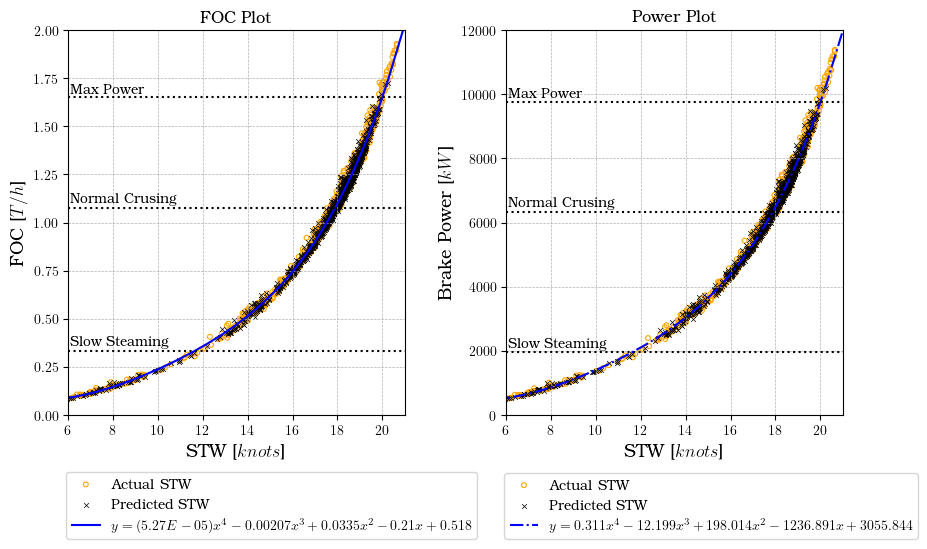

In [97]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_yr,coefs_pred_et_yr = FOC_coeff_plot(stw_pred_et_yr,stw_act_yr,FOC_pred_yr,FOC_act_yr)
plt.sca(axes[1])
Pb_plot(stw_pred_et_yr,stw_act_yr,P_b_pred_yr,P_b_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)

plt.show()

Compare FOC plot

Coefficients for FOC curve
[ 5.30726824e-05 -2.10517534e-03  3.48175652e-02 -2.24766185e-01
  5.72744008e-01]
[ 5.98800408e-05 -2.42488584e-03  4.01035375e-02 -2.60854029e-01
  6.58381632e-01]
Coefficients for FOC curve
[ 5.13547470e-05 -1.98950390e-03  3.19063888e-02 -1.94366353e-01
  4.70113420e-01]
[ 5.99951256e-05 -2.40250215e-03  3.88601665e-02 -2.42610917e-01
  5.85336506e-01]


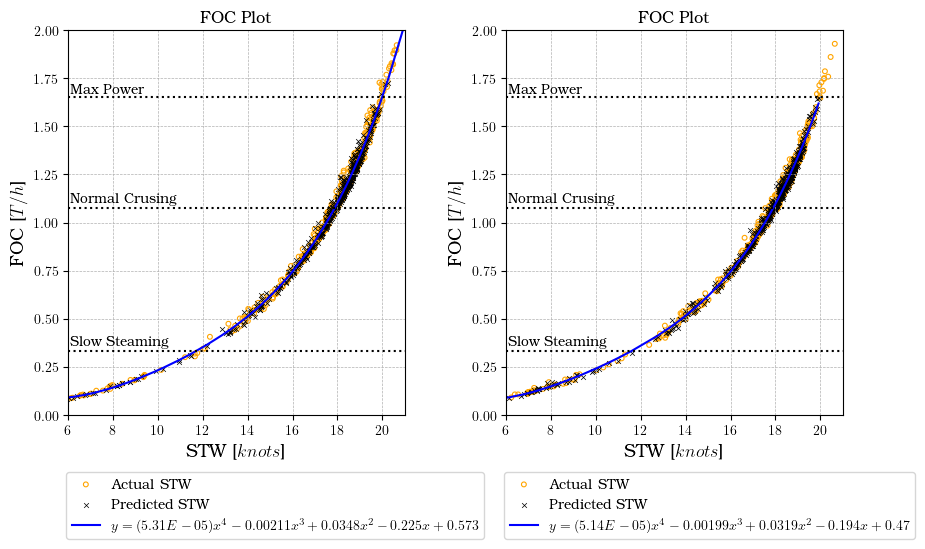

In [98]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_s,coefs_pred_et_s = FOC_coeff_plot(stw_pred_et_s,stw_act_s,FOC_pred_s,FOC_act_s)
plt.sca(axes[1])
coefs_act_w,coefs_pred_et_w = FOC_coeff_plot(stw_pred_et_w,stw_act_w,FOC_pred_w,FOC_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)

plt.show()

Compare Power Plot

Coefficients for power curve
[ 3.13298007e-01 -1.24272452e+01  2.05534623e+02 -1.32683698e+03
  3.38101540e+03]
[ 3.53483122e-01 -1.43145563e+01  2.36738710e+02 -1.53987030e+03
  3.88655036e+03]
Coefficients for power curve
[ 3.03156712e-01 -1.17444150e+01  1.88349403e+02 -1.14738107e+03
  2.77516777e+03]
[ 3.54162489e-01 -1.41824212e+01  2.29398858e+02 -1.43217778e+03
  3.45535128e+03]


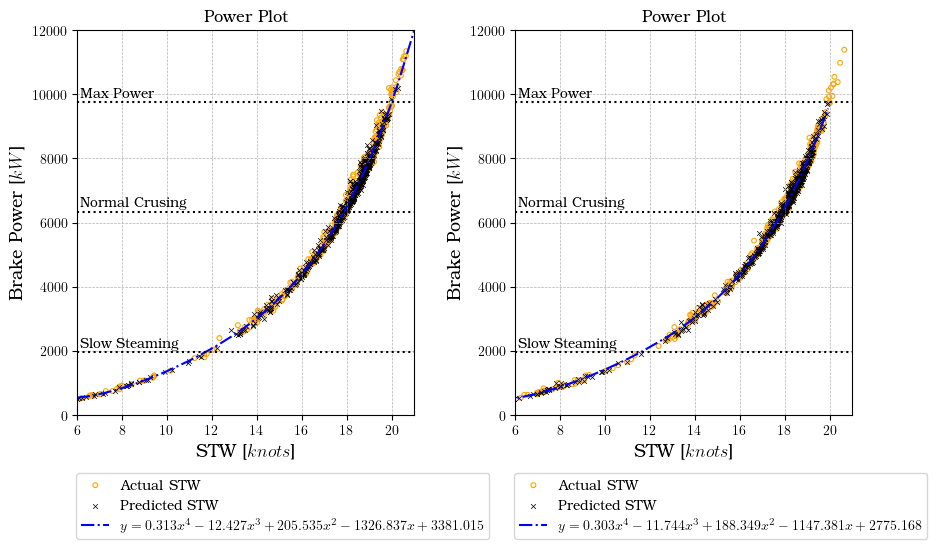

In [99]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
Pb_plot(stw_pred_et_s,stw_act_s,P_b_pred_s,P_b_act_s)
plt.sca(axes[1])
Pb_plot(stw_pred_et_w,stw_act_w,P_b_pred_w,P_b_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

RFR

Compare FOC plot

Coefficients for FOC curve
[ 5.17324374e-05 -2.03255773e-03  3.33987104e-02 -2.13005091e-01
  5.38098056e-01]
[ 5.98800408e-05 -2.42488584e-03  4.01035375e-02 -2.60854029e-01
  6.58381632e-01]
Coefficients for FOC curve
[ 5.24158185e-05 -2.04048106e-03  3.27847713e-02 -2.00788790e-01
  4.86797637e-01]
[ 5.99951256e-05 -2.40250215e-03  3.88601665e-02 -2.42610917e-01
  5.85336506e-01]


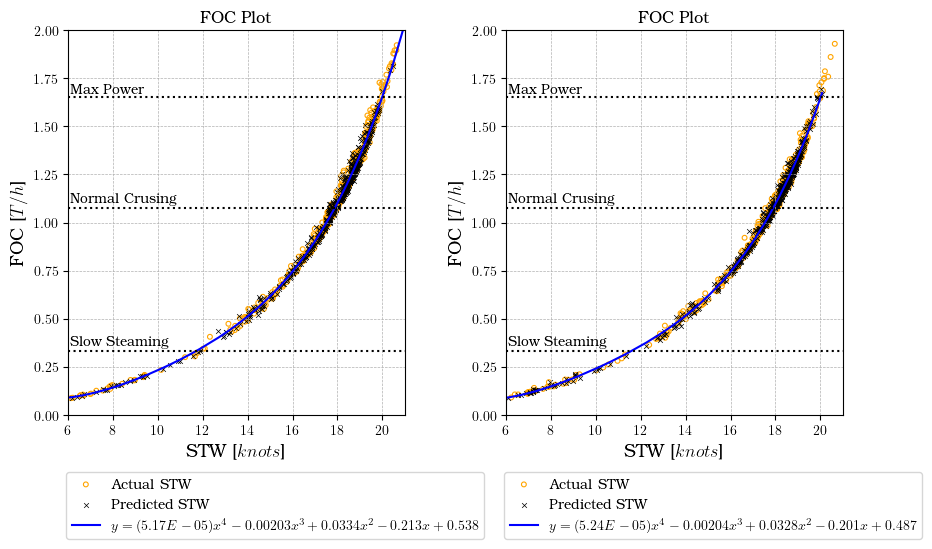

In [100]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_s,coefs_pred_rf_s = FOC_coeff_plot(stw_pred_rf_s,stw_act_s,FOC_pred_rf_s,FOC_act_s)
plt.sca(axes[1])
coefs_act_w,coefs_pred_rf_w = FOC_coeff_plot(stw_pred_rf_w,stw_act_w,FOC_pred_rf_w,FOC_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)

plt.show()

Compare Power plot

Coefficients for power curve
[ 3.05386289e-01 -1.19985698e+01  1.97158857e+02 -1.25740904e+03
  3.17649384e+03]
[ 3.53483122e-01 -1.43145563e+01  2.36738710e+02 -1.53987030e+03
  3.88655036e+03]
Coefficients for power curve
[ 3.09420416e-01 -1.20453427e+01  1.93534659e+02 -1.18529392e+03
  2.87365783e+03]
[ 3.54162489e-01 -1.41824212e+01  2.29398858e+02 -1.43217778e+03
  3.45535128e+03]


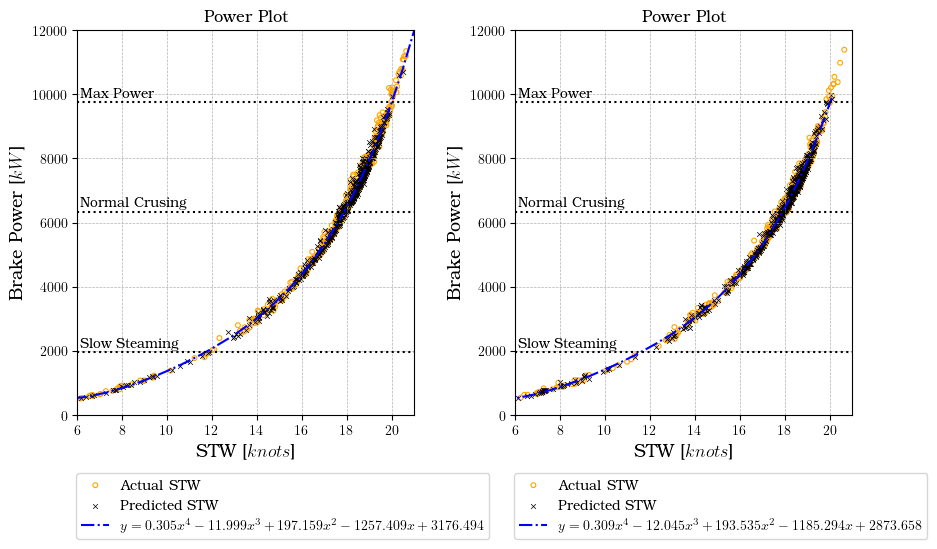

In [101]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
Pb_plot(stw_pred_rf_s,stw_act_s,P_b_pred_rf_s,P_b_act_s)
plt.sca(axes[1])
Pb_plot(stw_pred_rf_w,stw_act_w,P_b_pred_rf_w,P_b_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

DTR

compare FOC plot

Coefficients for FOC curve
[ 4.74035692e-05 -1.82487824e-03  2.98266000e-02 -1.86797032e-01
  4.67636198e-01]
[ 5.98800408e-05 -2.42488584e-03  4.01035375e-02 -2.60854029e-01
  6.58381632e-01]
Coefficients for FOC curve
[ 4.23851100e-05 -1.54019370e-03  2.38755277e-02 -1.34165545e-01
  3.10490671e-01]
[ 5.99951256e-05 -2.40250215e-03  3.88601665e-02 -2.42610917e-01
  5.85336506e-01]


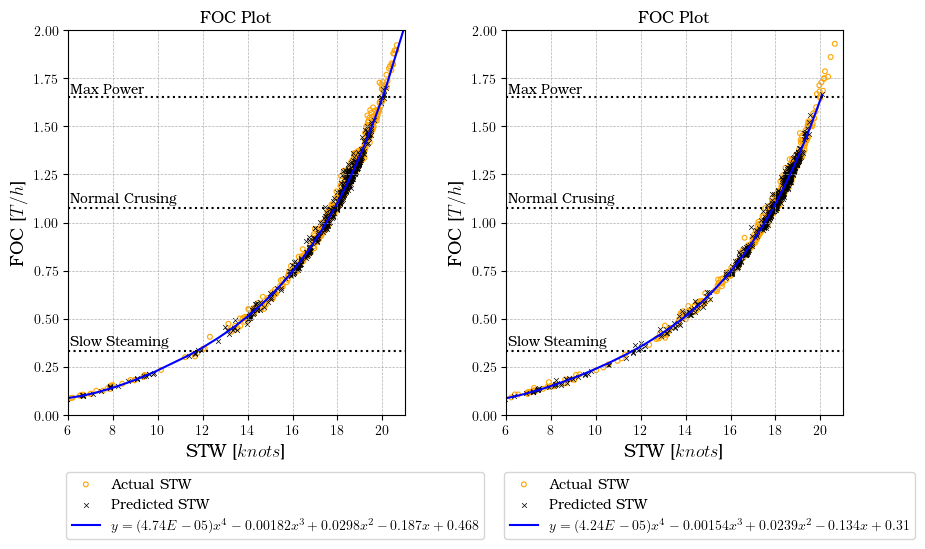

In [102]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_s,coefs_pred_dt_s = FOC_coeff_plot(stw_pred_dt_s,stw_act_s,FOC_pred_dt_s,FOC_act_s)
plt.sca(axes[1])
coefs_act_w,coefs_pred_dt_w = FOC_coeff_plot(stw_pred_dt_w,stw_act_w,FOC_pred_dt_w,FOC_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

Compare power plot

Coefficients for power curve
[ 2.79832168e-01 -1.07725988e+01  1.76072019e+02 -1.10269795e+03
  2.76054426e+03]
[ 3.53483122e-01 -1.43145563e+01  2.36738710e+02 -1.53987030e+03
  3.88655036e+03]
Coefficients for power curve
[ 2.50207261e-01 -9.09205256e+00  1.40941722e+02 -7.92004399e+02
  1.83288472e+03]
[ 3.54162489e-01 -1.41824212e+01  2.29398858e+02 -1.43217778e+03
  3.45535128e+03]


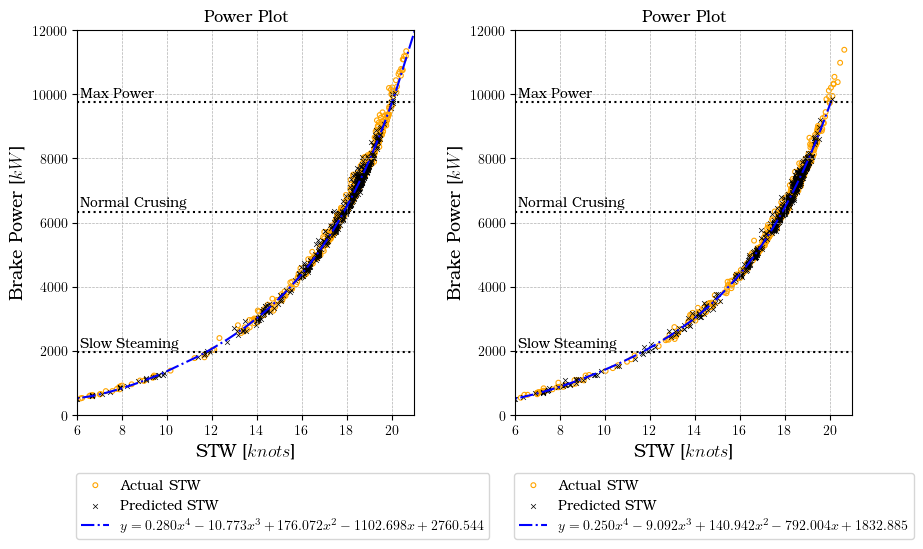

In [103]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
Pb_plot(stw_pred_dt_s,stw_act_s,P_b_pred_dt_s,P_b_act_s)
plt.sca(axes[1])
Pb_plot(stw_pred_dt_w,stw_act_w,P_b_pred_dt_w,P_b_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

MLR

compare FOC Plot

Coefficients for FOC curve
[ 5.45230701e-05 -2.17280915e-03  3.57306556e-02 -2.26755703e-01
  5.55933553e-01]
[ 5.98800408e-05 -2.42488584e-03  4.01035375e-02 -2.60854029e-01
  6.58381632e-01]
Coefficients for FOC curve
[ 4.02862370e-06  4.26102450e-04 -1.17045569e-02  1.31084110e-01
 -3.71050735e-01]
[ 5.99951256e-05 -2.40250215e-03  3.88601665e-02 -2.42610917e-01
  5.85336506e-01]


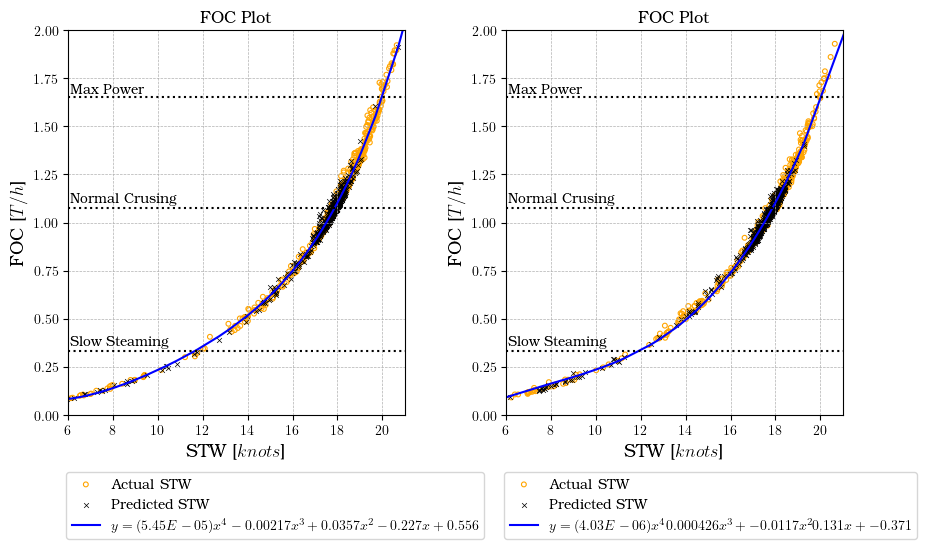

In [104]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_s,coefs_pred_mlr_s = FOC_coeff_plot(stw_pred_mlr_s,stw_act_s,FOC_pred_mlr_s,FOC_act_s)
plt.sca(axes[1])
coefs_act_w,coefs_pred_mlr_w = FOC_coeff_plot(stw_pred_mlr_w,stw_act_w,FOC_pred_mlr_w,FOC_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

compare power plot

Coefficients for power curve
[ 3.21859918e-01 -1.28265003e+01  2.10924768e+02 -1.33858148e+03
  3.28178012e+03]
[ 3.53483122e-01 -1.43145563e+01  2.36738710e+02 -1.53987030e+03
  3.88655036e+03]
Coefficients for power curve
[ 2.37817220e-02  2.51536275e+00 -6.90941967e+01  7.73814108e+02
 -2.19038214e+03]
[ 3.54162489e-01 -1.41824212e+01  2.29398858e+02 -1.43217778e+03
  3.45535128e+03]


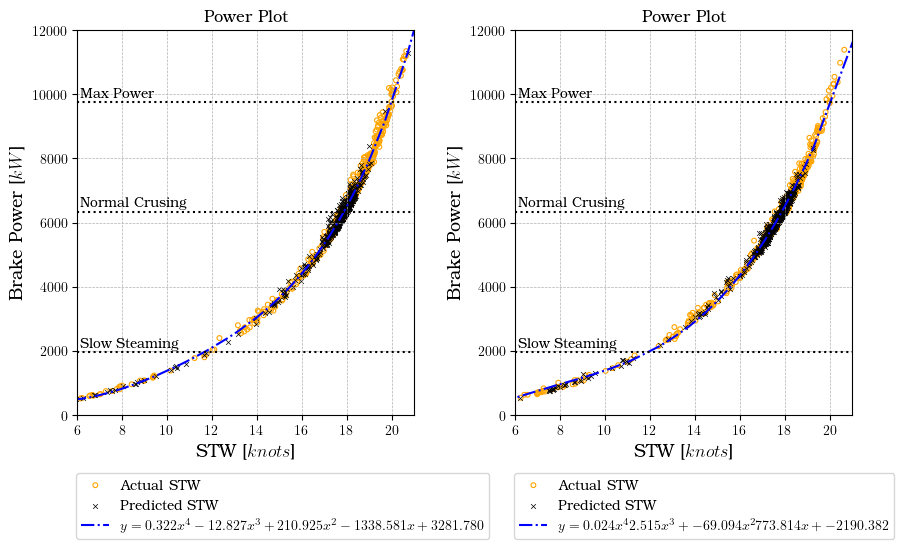

In [105]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
Pb_plot(stw_pred_mlr_s,stw_act_s,P_b_pred_mlr_s,P_b_act_s)
plt.sca(axes[1])
Pb_plot(stw_pred_mlr_w,stw_act_w,P_b_pred_mlr_w,P_b_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

In [106]:
import random

# # Simulate model performance by inserting arbitrary STW in knots

# # Complete Random number with no distribution

# def generate_random_integers(min_value, max_value, n):
#     random_numbers = [random.uniform(min_value, max_value) for _ in range(n)]
#     return random_numbers
# # speed range, 5-21 kts, simulate 18h journey time in a day over a month so (18*31)
# v_stw_lst = generate_random_integers(19.5,21,558) 
# v_stw = np.array(v_stw_lst)
# print(v_stw)

# # Simulate one way trip

# v_stw_lst_day = [17.27621092,18.9989056,19.33427835,18.91104651,13.85493274]
# v_stw = np.array(v_stw_lst_day)

# Skewed distribution of random numbers

# Parameters for the right-skewed normal distribution
mean = 17  # Mean of the distribution
std_dev = -3.176740  # Standard deviation of the distribution
skewness_factor = .3  # Skewness factor to control the skewness

# Range of the random numbers you want to generate
minimum = 5
maximum = 21

# Generate random numbers with a standard normal distribution
n = 558  # Number of random numbers to generate
standard_normal_values = np.random.randn(n)

# Transform the standard normal distribution into a right-skewed distribution
right_skewed_values = mean + std_dev * np.exp(skewness_factor * standard_normal_values)

# Scale and shift the values to the desired range
scaled_values = (right_skewed_values - np.min(right_skewed_values)) / (np.max(right_skewed_values) - np.min(right_skewed_values))
v_stw = minimum + scaled_values * (maximum - minimum)

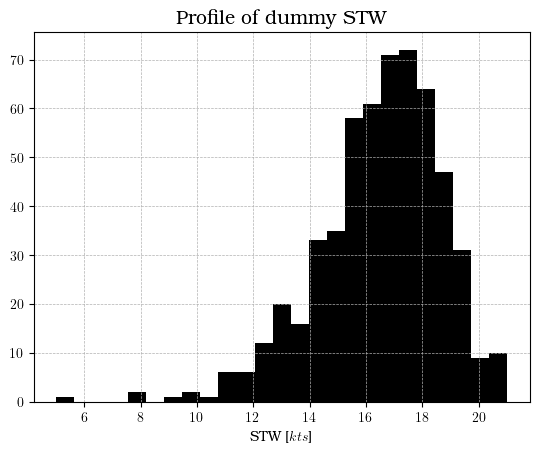

In [107]:
plt.hist(v_stw,bins=25,color='black')
plt.grid(True,linestyle = '--', linewidth = 0.5)
plt.xlabel(r"STW [$kts$]",fontsize=10)
plt.title(r"Profile of dummy STW", fontsize=14)
plt.show()

Actual

In [108]:
#Summer
FOC_poly_act_s = coefs_act_s[0]*v_stw**4 + coefs_act_s[1] * v_stw**3 + coefs_act_s[2] * v_stw**2 + coefs_act_s[3]*v_stw + coefs_act_s[4]
#Winter
FOC_poly_act_w = coefs_act_w[0]*v_stw**4 + coefs_act_w[1] * v_stw**3 + coefs_act_w[2] * v_stw**2 + coefs_act_w[3]*v_stw + coefs_act_s[4]
#Year
FOC_poly_act_yr = coefs_act_yr[0]*v_stw**4 + coefs_act_yr[1] * v_stw**3 + coefs_act_yr[2] * v_stw**2 + coefs_act_yr[3]*v_stw + coefs_act_yr[4]

ETR

In [109]:
#Summer
FOC_poly_pred_s = coefs_pred_et_s[0]*v_stw**4 + coefs_pred_et_s[1] * v_stw**3 + coefs_pred_et_s[2] * v_stw**2 + coefs_pred_et_s[3]*v_stw + coefs_pred_et_s[4]
#Winter
FOC_poly_pred_w = coefs_pred_et_w[0]*v_stw**4 + coefs_pred_et_w[1] * v_stw**3 + coefs_pred_et_w[2] * v_stw**2 + coefs_pred_et_w[3]*v_stw + coefs_pred_et_w[4]
#Yearly
FOC_poly_pred_yr = coefs_pred_et_yr[0]*v_stw**4 + coefs_pred_et_yr[1] * v_stw**3 + coefs_pred_et_yr[2] * v_stw**2 + coefs_pred_et_yr[3]*v_stw + coefs_pred_et_yr[4]


RFR

In [110]:
#Summer
FOC_poly_rf_s = coefs_pred_rf_s[0]*v_stw**4 + coefs_pred_rf_s[1] * v_stw**3 + coefs_pred_rf_s[2] * v_stw**2 + coefs_pred_rf_s[3]*v_stw + coefs_pred_rf_s[4]
#Winter
FOC_poly_rf_w = coefs_pred_rf_w[0]*v_stw**4 + coefs_pred_rf_w[1] * v_stw**3 + coefs_pred_rf_w[2] * v_stw**2 + coefs_pred_rf_w[3]*v_stw + coefs_pred_rf_w[4]


DTR

In [111]:
#Summer
FOC_poly_dt_s = coefs_pred_dt_s[0]*v_stw**4 + coefs_pred_dt_s[1] * v_stw**3 + coefs_pred_dt_s[2] * v_stw**2 + coefs_pred_dt_s[3]*v_stw + coefs_pred_dt_s[4]
#Winter
FOC_poly_dt_w = coefs_pred_dt_w[0]*v_stw**4 + coefs_pred_dt_w[1] * v_stw**3 + coefs_pred_dt_w[2] * v_stw**2 + coefs_pred_dt_w[3]*v_stw + coefs_pred_dt_w[4]


MLR

In [112]:
#Summer
FOC_poly_mlr_s = coefs_pred_mlr_s[0]*v_stw**4 + coefs_pred_mlr_s[1] * v_stw**3 + coefs_pred_mlr_s[2] * v_stw**2 + coefs_pred_mlr_s[3]*v_stw + coefs_pred_mlr_s[4]
#Winter
FOC_poly_mlr_w = coefs_pred_mlr_w[0]*v_stw**4 + coefs_pred_mlr_w[1] * v_stw**3 + coefs_pred_mlr_w[2] * v_stw**2 + coefs_pred_mlr_w[3]*v_stw + coefs_pred_mlr_w[4]


Polyfit model performance 

In [113]:
# This model defines the performance of the generated polyfit line from the model

def evaluate_FOC_poly(model,FOC_poly_act,FOC_poly_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_ply = r2_score(FOC_poly_act,FOC_poly_pred)
    expVar_ply = explained_variance_score(FOC_poly_act,FOC_poly_pred)
    MAE_ply = mean_absolute_error(FOC_poly_act,FOC_poly_pred)
    RMSE_ply = np.sqrt(mean_squared_error(FOC_poly_act,FOC_poly_pred))
    MAD_ply = median_absolute_error(FOC_poly_act,FOC_poly_pred)
    MAPE_ply = mean_absolute_percentage_error(FOC_poly_act,FOC_poly_pred)
    
    n = len(FOC_poly_act)
    num_params = 4 + 1 # 4th order model is best fit
    aic_ply = n * np.log(mean_squared_error(FOC_poly_act,FOC_poly_pred)) + 2 * num_params

    print(f"Model Performance of {model}")
    print(f"AIC {aic_ply:0.4f}")
    print(f"R^2 {Rsquared_ply:0.4f}")
    print(f"Explained Variance {expVar_ply:0.4f}")
    print(f"MAE {MAE_ply:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_ply:0.4f} T/h")
    print(f"MAD {MAD_ply:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_ply*100:0.4f} %")

ETR

In [114]:
# Yearly
evaluate_FOC_poly(model_etr_hpov,FOC_poly_act_yr,FOC_poly_pred_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC -6281.6371
R^2 0.9999
Explained Variance 0.9999
MAE 0.0023 T/h
RMSE FOC 0.0036 T/h
MAD 0.0021 T/h
MAPE FOC 0.2719 %


In [115]:
# Summer
evaluate_FOC_poly(model_etr_hpov,FOC_poly_act_s,FOC_poly_pred_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC -6347.3705
R^2 0.9999
Explained Variance 0.9999
MAE 0.0022 T/h
RMSE FOC 0.0034 T/h
MAD 0.0019 T/h
MAPE FOC 0.2468 %


In [116]:
# Winter
evaluate_FOC_poly(model_etr_hpov,FOC_poly_act_w,FOC_poly_pred_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC -2909.2003
R^2 0.9535
Explained Variance 0.9999
MAE 0.0730 T/h
RMSE FOC 0.0731 T/h
MAD 0.0718 T/h
MAPE FOC 8.7301 %


RFR

In [117]:
# Summer
evaluate_FOC_poly(model_rfr_hpov,FOC_poly_act_s,FOC_poly_rf_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
AIC -6293.7611
R^2 0.9999
Explained Variance 0.9999
MAE 0.0023 T/h
RMSE FOC 0.0035 T/h
MAD 0.0019 T/h
MAPE FOC 0.2607 %


In [118]:
# Winter
evaluate_FOC_poly(model_rfr_hpov,FOC_poly_act_w,FOC_poly_rf_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
AIC -2907.4410
R^2 0.9533
Explained Variance 0.9999
MAE 0.0732 T/h
RMSE FOC 0.0732 T/h
MAD 0.0721 T/h
MAPE FOC 8.7535 %


DTR

In [119]:
# Summer
evaluate_FOC_poly(model_dtr_hpov,FOC_poly_act_s,FOC_poly_dt_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
AIC -5760.9184
R^2 0.9997
Explained Variance 0.9997
MAE 0.0036 T/h
RMSE FOC 0.0057 T/h
MAD 0.0031 T/h
MAPE FOC 0.4175 %


In [120]:
# Winter
evaluate_FOC_poly(model_dtr_hpov,FOC_poly_act_w,FOC_poly_dt_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
AIC -2892.2662
R^2 0.9520
Explained Variance 0.9996
MAE 0.0739 T/h
RMSE FOC 0.0742 T/h
MAD 0.0718 T/h
MAPE FOC 8.8483 %


MLR

In [121]:
# Summer
evaluate_FOC_poly(model_mlr_ftr,FOC_poly_act_s,FOC_poly_mlr_s)

Model Performance of LinearRegression()
AIC -5956.9491
R^2 0.9998
Explained Variance 0.9999
MAE 0.0040 T/h
RMSE FOC 0.0048 T/h
MAD 0.0042 T/h
MAPE FOC 0.5186 %


In [122]:
# Winter
evaluate_FOC_poly(model_mlr_ftr,FOC_poly_act_w,FOC_poly_mlr_w)

Model Performance of LinearRegression()
AIC -2803.2589
R^2 0.9437
Explained Variance 0.9979
MAE 0.0789 T/h
RMSE FOC 0.0804 T/h
MAD 0.0744 T/h
MAPE FOC 9.6965 %


Absolute model performance

In [123]:
# This function defines the model performance for the given stw range

def evaluate_FOC(model,FOC_act,FOC_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_FOC = r2_score(FOC_act,FOC_pred)
    expVar_FOC = explained_variance_score(FOC_act,FOC_pred)
    MAE_FOC = mean_absolute_error(FOC_act,FOC_pred)
    RMSE_FOC = np.sqrt(mean_squared_error(FOC_act, FOC_pred))
    MAD_FOC = median_absolute_error(FOC_act,FOC_pred)
    MAPE_FOC = mean_absolute_percentage_error(FOC_act, FOC_pred)
    
    n = len(FOC_act)
    num_params = model.n_features_in_
    aic = n * math.log(mean_squared_error(FOC_act, FOC_pred)) + 2 * num_params

    print(f"Model Performance of {model}")
    print(f"AIC {aic:0.4f}")
    print(f"R^2 {Rsquared_FOC:0.4f}")
    print(f"Explained Variance {expVar_FOC:0.4f}")
    print(f"MAE {MAE_FOC:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_FOC:0.4f} T/h")
    print(f"MAD {MAD_FOC:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_FOC*100:0.4f} %")


ETR

In [124]:
# Yearly performance 

evaluate_FOC(model_etr_hpov,FOC_act_yr,FOC_pred_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC -4149.1584
R^2 0.9188
Explained Variance 0.9220
MAE 0.0675 T/h
RMSE FOC 0.1130 T/h
MAD 0.0390 T/h
MAPE FOC 7.1595 %


In [125]:
evaluate_FOC(model_etr_hpov,FOC_act_s,FOC_pred_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC -1742.7177
R^2 0.8773
Explained Variance 0.8863
MAE 0.0848 T/h
RMSE FOC 0.1429 T/h
MAD 0.0449 T/h
MAPE FOC 8.4661 %


In [126]:
evaluate_FOC(model_etr_hpov,FOC_act_w,FOC_pred_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC -2560.4659
R^2 0.9597
Explained Variance 0.9601
MAE 0.0519 T/h
RMSE FOC 0.0766 T/h
MAD 0.0351 T/h
MAPE FOC 5.9802 %


RFR

In [127]:
evaluate_FOC(model_rfr_hpov,FOC_act_s,FOC_pred_rf_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
AIC -1719.5560
R^2 0.8709
Explained Variance 0.8803
MAE 0.0849 T/h
RMSE FOC 0.1466 T/h
MAD 0.0402 T/h
MAPE FOC 8.5473 %


In [128]:
evaluate_FOC(model_rfr_hpov,FOC_act_w,FOC_pred_rf_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
AIC -2629.3254
R^2 0.9648
Explained Variance 0.9651
MAE 0.0468 T/h
RMSE FOC 0.0715 T/h
MAD 0.0297 T/h
MAPE FOC 5.6137 %


DTR

In [129]:
evaluate_FOC(model_dtr_hpov,FOC_act_s,FOC_pred_dt_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
AIC -1376.7812
R^2 0.7252
Explained Variance 0.7405
MAE 0.1416 T/h
RMSE FOC 0.2138 T/h
MAD 0.0887 T/h
MAPE FOC 14.4653 %


In [130]:
evaluate_FOC(model_dtr_hpov,FOC_act_w,FOC_pred_dt_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
AIC -1904.2648
R^2 0.8514
Explained Variance 0.8521
MAE 0.1017 T/h
RMSE FOC 0.1471 T/h
MAD 0.0682 T/h
MAPE FOC 11.9289 %


MLR

In [131]:
evaluate_FOC(model_mlr_ftr,FOC_act_s,FOC_pred_mlr_s)

Model Performance of LinearRegression()
AIC -1049.4190
R^2 0.4349
Explained Variance 0.4901
MAE 0.2332 T/h
RMSE FOC 0.3066 T/h
MAD 0.1820 T/h
MAPE FOC 25.1659 %


In [132]:
evaluate_FOC(model_mlr_ftr,FOC_act_w,FOC_pred_mlr_w)

Model Performance of LinearRegression()
AIC -999.7961
R^2 0.1027
Explained Variance 0.1160
MAE 0.2122 T/h
RMSE FOC 0.3614 T/h
MAD 0.1581 T/h
MAPE FOC 33.0321 %


In [133]:
# fs = 10

# plt.rcParams.update(plt.rcParamsDefault)
# # Parameter to plot in nice latex fonts
# plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})


# stw = stw_pred
# R_f = Rf_pred/1e3
# R_app = R_app_pred/1e3
# R_w = R_w_pred/1e3
# R_b = R_b_pred/1e3
# R_tr = R_tr_pred/1e3
# R_a = R_a_pred/1e3
# R_aa = R_aa_pred/1e3
# # R_aa_hm = dfprog_f['R_aa_hm']/1e3
# R_awl = R_awl_pred/1e3
# R_tot = R_tot_pred
# # eff_h = dfprog_f['eff_h']
# eff_tot = eff_tot_pred
# P_b = P_b_pred
# FOC = FOC_pred



# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

# axes[0, 0].hist(stw,bins=25,color='black')
# axes[0, 0].set_title(r'Speed Thorugh Water $[STW]$', fontsize=fs)
# axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[0, 1].hist(R_f,bins=25,color='black')
# axes[0, 1].set_title(r'Frictional Resistance $[kN]$', fontsize=fs)
# axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[0, 2].hist(R_app,bins=25,color='black')
# axes[0, 2].set_title(r'Appendage Resistance $[kN]$', fontsize=fs)
# axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[1, 0].hist(R_w,bins=25,color='black')
# axes[1, 0].set_title(r'Wave Making-Breaking Resistance $[kN]$', fontsize=fs)
# axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[1, 1].hist(R_b  ,bins=25,color='black')
# axes[1, 1].set_title(r'Bulbous Bow Resistance $[kN]$', fontsize=fs)
# axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[1, 2].hist(R_a,bins=25,color='black')
# axes[1, 2].set_title(r'Correlation Resistance $[kN]$', fontsize=fs)
# axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[2, 0].hist(R_aa,bins=25,color='black')
# axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

# # axes[2, 0].hist(R_aa_hm,bins=25,color='black')
# # axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# # axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[2, 1].hist(R_awl,bins=25,color='black')
# axes[2, 1].set_title(r'Wave Resistance STAWAVE-1 $[kN]$', fontsize=fs)
# axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[2, 2].hist(R_tr,bins=25,color='black')
# axes[2, 2].set_title(r'Transom Resistance $[kN]$', fontsize=fs)
# axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 0].hist(R_tot,bins=25,color='black')
# axes[3, 0].set_title(r'Total Resistance $[kN]$', fontsize=fs)
# axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# # axes[3, 0].hist(eff_h,bins=25,color='black')
# # axes[3, 0].set_title(r'Hull Efficiency $[-]$', fontsize=fs)
# # axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 1].hist(eff_tot,bins=25,color='black')
# axes[3, 1].set_title(r'Total Efficiency $[-]$', fontsize=fs)
# axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 2].hist(P_b,bins=25,color='black')
# axes[3, 2].set_title(r'Power $[kW]$', fontsize=fs)
# axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

# # axes[4, 1].hist(FOC,bins=25,color='black')
# # axes[4, 1].set_title(r'Fuel Consumption $[t/h]$', fontsize=fs)
# # axes[4, 1].grid(True,linestyle = '--', linewidth = 0.5)

# fig.subplots_adjust(hspace=0.4)
# plt.show()